In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import pickle

import lightgbm as lgb
print("Lightgbm version:", lgb.__version__)

import sys
sys.path.append("../src")
from preproc import process_train_data, process_test_data

Lightgbm version: 4.5.0


***
### load and preprocess data

In [2]:
# define some paths
path_raw = Path("../data/raw")
path_processed = Path("../data/processed")
path_results = Path("../data/results")

# load data
df_train = pd.read_csv(path_raw / "train.csv")
df_test = pd.read_csv(path_raw / "test.csv")

df_train

Id GameRulesetName                                        agent1  \
0            0             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
1            1             00Y        MCTS-ProgressiveHistory-0.1-MAST-false   
2            2             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
3            3             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
4            4             00Y         MCTS-ProgressiveHistory-0.1-MAST-true   
...        ...             ...                                           ...   
233229  233229     Zuz_Mel_7x7        MCTS-UCB1Tuned-1.41421356237-NST-false   
233230  233230     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233231  233231     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233232  233232     Zuz_Mel_7x7  MCTS-UCB1Tuned-1.41421356237-Random200-false   
233233  233233     Zuz_Mel_7x7   MCTS-UCB1Tuned-1.41421356237-Random200-true   

                                                   agent2  Properties  Format  \
0             MCTS-ProgressiveHistory-0.6-Random200-false           1       1   
1                             MCTS-UCB1GRAVE-0.6-NST-true           1       1   
2                                 MCTS-UCB1-0.1-NST-false           1       1   
3                                 MCTS-UCB1-0.6-NST-false           1       1   
4                  MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
...                                                   ...         ...     ...   
233229  MCTS-ProgressiveHistory-1.41421356237-Random20...           1       1   
233230                           MCTS-UCB1-0.6-MAST-false           1       1   
233231             MCTS-UCB1GRAVE-1.41421356237-NST-false           1       1   
233232              MCTS-UCB1GRAVE-1.41421356237-NST-true           1       1   
233233                      MCTS-UCB1Tuned-0.6-MAST-false           1       1   

        Time  Discrete  Realtime  Turns  ...  DoLudeme  Trigger  \
0          1         1         0      1  ...         0        1   
1          1         1         0      1  ...         0        1   
2          1         1         0      1  ...         0        1   
3          1         1         0      1  ...         0        1   
4          1         1         0      1  ...         0        1   
...      ...       ...       ...    ...  ...       ...      ...   
233229     1         1         0      1  ...         0        0   
233230     1         1         0      1  ...         0        0   
233231     1         1         0      1  ...         0        0   
233232     1         1         0      1  ...         0        0   
233233     1         1         0      1  ...         0        0   

        PlayoutsPerSecond  MovesPerSecond  \
0                  298.07        18877.17   
1                  298.07        18877.17   
2                  298.07        18877.17   
3                  298.07        18877.17   
4                  298.07        18877.17   
...                   ...             ...   
233229             157.52       157174.58   
233230             157.52       157174.58   
233231             157.52       157174.58   
233232             157.52       157174.58   
233233             157.52       157174.58   

                                             EnglishRules  \
0       Goal: Connect all three edge colors with a sin...   
1       Goal: Connect all three edge colors with a sin...   
2       Goal: Connect all three edge colors with a sin...   
3       Goal: Connect all three edge colors with a sin...   
4       Goal: Connect all three edge colors with a sin...   
...                                                   ...   
233229  7x7 board. 24 pieces per player. Pieces begin ...   
233230  7x7 board. 24 pieces per player. Pieces begin ...   
233231  7x7 board. 24 pieces per player. Pieces begin ...   
233232  7x7 board. 24 pieces per player. Pieces begin ...   
233233  7x7 board. 24 pieces per player. Pieces begin ...   


In [3]:
# input parameters
fs_type = 'fsv24'
train_type = "large"

In [4]:
# Parameters
fs_type = "uni85"


In [5]:
# Load the feature selection results
fs_mapping = {
    "full": None,
    "fsv2": '../feat_selection/select_optuna_lgbm_v2.json',
    "fsv3": '../feat_selection/select_optuna_catb.json',
    "fsv4": '../feat_selection/select_optuna_lgbm_v3.json',
    "fsv23": '../feat_selection/select_optuna_combined_v23.json',
    "fsv24": '../feat_selection/select_optuna_combined_v24.json',
    "fsv34": '../feat_selection/select_optuna_combined_v34.json',
    "int95": '../feat_selection/feat_selection_intersection_at_95.json',
    "int96": '../feat_selection/feat_selection_intersection_at_96.json',
    "int97": '../feat_selection/feat_selection_intersection_at_97.json',
    "int98": '../feat_selection/feat_selection_intersection_at_98.json',
    "int99": '../feat_selection/feat_selection_intersection_at_99.json',
    "uni80": '../feat_selection/feat_selection_union_at_80.json',
    "uni85": '../feat_selection/feat_selection_union_at_85.json',
    "uni90": '../feat_selection/feat_selection_union_at_90.json',
    "uni95": '../feat_selection/feat_selection_union_at_95.json',
}

fs_path = fs_mapping[fs_type]

if fs_path is None:
    feature_selection = dict()
else:
    with open(fs_path, 'r') as f:
        feature_selection = json.load(f)

# Extract the selected features
numerical_cols = feature_selection.get('numerical', None)
categorical_cols = feature_selection.get('categorical', None)

# text_cols = ["LudRules",]
text_cols = list()

print("Numerical features:", len(numerical_cols) if numerical_cols else 0)
print("Categorical features:", len(categorical_cols) if categorical_cols else 0)
print("Text features:", len(text_cols) if text_cols else 0)

Numerical features: 264
Categorical features: 8
Text features: 0


In [6]:
df_train, numerical_cols, categorical_cols, encoder, scaler = process_train_data(
    df_train,
    scale=False,
    numerical_cols=numerical_cols,
    categorical_cols=categorical_cols,
    include_position_features=True,
    include_text_features=False,
)

# Print the results
print("Numerical Columns:", len(numerical_cols))
print("Categorical Columns:", len(categorical_cols))

number of all nan cols:  0


number of constant cols:  0


Numerical Columns: 336
Categorical Columns: 8


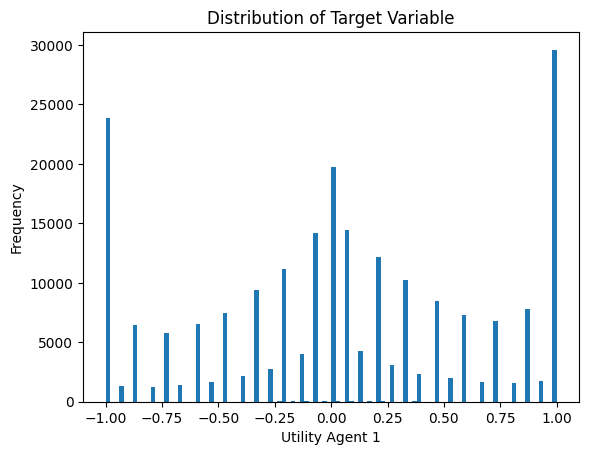

In [7]:
plt.hist(df_train['utility_agent1'], bins=100)
plt.title('Distribution of Target Variable')
plt.xlabel('Utility Agent 1')
plt.ylabel('Frequency')
plt.show()

In [8]:
split1 = pickle.load(open('../data/splits/cv1_Game.pkl', 'rb'))
split2 = pickle.load(open('../data/splits/cv2_Game.pkl', 'rb'))
split3 = pickle.load(open('../data/splits/cv3_Game.pkl', 'rb'))

# split1 = pickle.load(open('../data/splits/cv1_GameRulesetName.pkl', 'rb'))
# split2 = pickle.load(open('../data/splits/cv2_GameRulesetName.pkl', 'rb'))
# split3 = pickle.load(open('../data/splits/cv3_GameRulesetName.pkl', 'rb'))

***
### train model


In [9]:
if train_type == "small":
    LEARNING_RATE = 0.08
    NUM_BOOST_ROUND = 2500
elif train_type == "medium":
    LEARNING_RATE = 0.04
    NUM_BOOST_ROUND = 5000
elif train_type == "large":
    LEARNING_RATE = 0.02
    NUM_BOOST_ROUND = 10_000
elif train_type == "xlarge":
    LEARNING_RATE = 0.01
    NUM_BOOST_ROUND = 20_000


print(LEARNING_RATE, NUM_BOOST_ROUND)

0.02 10000


In [10]:
def train_models(
        df_train,
        numerical_cols,
        categorical_cols,
        target='utility_agent1',
        split_list=None,
    ):
    # Define the parameters
    params = {
        'objective': "regression",
        'metric': 'rmse',
        'boosting': 'gbdt',
        ###################
        'num_leaves': 31,
        'max_depth': 12,
        'learning_rate': LEARNING_RATE,
        ###################
        'min_data_in_leaf': 100,
        'bagging_freq': 1,
        'bagging_fraction': 0.8,
        'feature_fraction': 0.5,
        'verbose': -1,
        'seed': 2112,
    }

    trained_models = []
    oof = pd.DataFrame(
        index=df_train.index,
        columns=[f'{target}_true', f'{target}_pred', 'fold']
    )
    oof_scores = []
    feat_importance_dfs = []

    # Perform cross-validation
    for fold, (train_index, val_index) in enumerate(split_list, 1):
        print(f"Fold {fold}")
        
        # Split the data
        X_train, X_val = df_train.iloc[train_index], df_train.iloc[val_index]
        y_train, y_val = X_train[target], X_val[target]
        
        # Create LightGBM datasets
        train_data = lgb.Dataset(
            data=X_train[numerical_cols + categorical_cols],
            label=y_train,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )
        val_data = lgb.Dataset(
            data=X_val[numerical_cols + categorical_cols],
            label=y_val,
            categorical_feature=categorical_cols,
            free_raw_data=True
        )

        # Train the model
        model = lgb.train(
            params,
            train_data,
            num_boost_round=NUM_BOOST_ROUND,
            valid_sets=[val_data],
            callbacks=[
                lgb.log_evaluation(period=100),
            ]
        )
        
        # Get feature importance for this fold
        feat_importance = pd.DataFrame({
            'feature': numerical_cols + categorical_cols,
            f'importance_f{fold}': model.feature_importance(importance_type='gain')
        })
        feat_importance_dfs.append(feat_importance)
        
        # Plot feature importance
        lgb.plot_importance(model, figsize=(10, 8), importance_type='gain', max_num_features=50)
        plt.title('Top 50 Features by Importance')
        plt.tight_layout()
        plt.show()
        
        # Save the trained model to the list
        trained_models.append(model)

        # predict on validation set
        y_pred = model.predict(X_val[numerical_cols + categorical_cols])

        # Save out-of-fold predictions
        oof.loc[val_index, f'{target}_true'] = y_val
        oof.loc[val_index, f'{target}_pred'] = y_pred
        oof.loc[val_index, 'fold'] = fold
        
        # Compute RMSE
        y_pred = np.clip(y_pred, -1, 1)
        rmse = np.sqrt(np.mean((y_pred - y_val) ** 2))
        print(f"Fold {fold} - RMSE: {rmse}")

        # Save RMSE to the list
        oof_scores.append(rmse)

    # Combine feature importance dataframes
    importance_df = feat_importance_dfs[0]
    for df in feat_importance_dfs[1:]:
        importance_df = importance_df.merge(df, on='feature')
    
    # Calculate mean importance across folds
    importance_cols = [col for col in importance_df.columns if col.startswith('importance_f')]
    importance_df['importance_mean'] = importance_df[importance_cols].mean(axis=1)
    importance_df = importance_df.sort_values('importance_mean', ascending=False, ignore_index=True)
    importance_df['importance_relative'] = (
        importance_df['importance_mean'] / 
        importance_df['importance_mean'].sum()
    )

    # Print the list of oof scores and average oof score
    print("List of oof scores:", oof_scores)
    print("Average oof score:", np.mean(oof_scores))
    
    return trained_models, oof, oof_scores, importance_df

Fold 1


[100]	valid_0's rmse: 0.496899


[200]	valid_0's rmse: 0.478111


[300]	valid_0's rmse: 0.469683


[400]	valid_0's rmse: 0.46358


[500]	valid_0's rmse: 0.458843


[600]	valid_0's rmse: 0.45532


[700]	valid_0's rmse: 0.452199


[800]	valid_0's rmse: 0.449316


[900]	valid_0's rmse: 0.447116


[1000]	valid_0's rmse: 0.445278


[1100]	valid_0's rmse: 0.443925


[1200]	valid_0's rmse: 0.442698


[1300]	valid_0's rmse: 0.441723


[1400]	valid_0's rmse: 0.440834


[1500]	valid_0's rmse: 0.439901


[1600]	valid_0's rmse: 0.439193


[1700]	valid_0's rmse: 0.438613


[1800]	valid_0's rmse: 0.438186


[1900]	valid_0's rmse: 0.437618


[2000]	valid_0's rmse: 0.437043


[2100]	valid_0's rmse: 0.436609


[2200]	valid_0's rmse: 0.436277


[2300]	valid_0's rmse: 0.435793


[2400]	valid_0's rmse: 0.435534


[2500]	valid_0's rmse: 0.43512


[2600]	valid_0's rmse: 0.4348


[2700]	valid_0's rmse: 0.434592


[2800]	valid_0's rmse: 0.434426


[2900]	valid_0's rmse: 0.434215


[3000]	valid_0's rmse: 0.434216


[3100]	valid_0's rmse: 0.434029


[3200]	valid_0's rmse: 0.433797


[3300]	valid_0's rmse: 0.433595


[3400]	valid_0's rmse: 0.433373


[3500]	valid_0's rmse: 0.433258


[3600]	valid_0's rmse: 0.433145


[3700]	valid_0's rmse: 0.432984


[3800]	valid_0's rmse: 0.432881


[3900]	valid_0's rmse: 0.432745


[4000]	valid_0's rmse: 0.432671


[4100]	valid_0's rmse: 0.432544


[4200]	valid_0's rmse: 0.432476


[4300]	valid_0's rmse: 0.432331


[4400]	valid_0's rmse: 0.432231


[4500]	valid_0's rmse: 0.432142


[4600]	valid_0's rmse: 0.432026


[4700]	valid_0's rmse: 0.432081


[4800]	valid_0's rmse: 0.431968


[4900]	valid_0's rmse: 0.431823


[5000]	valid_0's rmse: 0.43172


[5100]	valid_0's rmse: 0.431645


[5200]	valid_0's rmse: 0.431513


[5300]	valid_0's rmse: 0.431453


[5400]	valid_0's rmse: 0.431459


[5500]	valid_0's rmse: 0.431449


[5600]	valid_0's rmse: 0.431414


[5700]	valid_0's rmse: 0.431385


[5800]	valid_0's rmse: 0.431312


[5900]	valid_0's rmse: 0.431231


[6000]	valid_0's rmse: 0.431173


[6100]	valid_0's rmse: 0.431124


[6200]	valid_0's rmse: 0.431069


[6300]	valid_0's rmse: 0.430996


[6400]	valid_0's rmse: 0.430919


[6500]	valid_0's rmse: 0.430868


[6600]	valid_0's rmse: 0.430886


[6700]	valid_0's rmse: 0.430974


[6800]	valid_0's rmse: 0.430951


[6900]	valid_0's rmse: 0.430904


[7000]	valid_0's rmse: 0.430879


[7100]	valid_0's rmse: 0.430869


[7200]	valid_0's rmse: 0.430851


[7300]	valid_0's rmse: 0.430814


[7400]	valid_0's rmse: 0.430796


[7500]	valid_0's rmse: 0.430704


[7600]	valid_0's rmse: 0.430648


[7700]	valid_0's rmse: 0.430658


[7800]	valid_0's rmse: 0.430629


[7900]	valid_0's rmse: 0.430577


[8000]	valid_0's rmse: 0.430641


[8100]	valid_0's rmse: 0.43059


[8200]	valid_0's rmse: 0.430629


[8300]	valid_0's rmse: 0.430616


[8400]	valid_0's rmse: 0.430606


[8500]	valid_0's rmse: 0.430576


[8600]	valid_0's rmse: 0.430581


[8700]	valid_0's rmse: 0.430551


[8800]	valid_0's rmse: 0.430533


[8900]	valid_0's rmse: 0.430523


[9000]	valid_0's rmse: 0.430513


[9100]	valid_0's rmse: 0.430493


[9200]	valid_0's rmse: 0.430512


[9300]	valid_0's rmse: 0.430508


[9400]	valid_0's rmse: 0.430492


[9500]	valid_0's rmse: 0.430466


[9600]	valid_0's rmse: 0.430443


[9700]	valid_0's rmse: 0.430487


[9800]	valid_0's rmse: 0.430445


[9900]	valid_0's rmse: 0.430416


[10000]	valid_0's rmse: 0.430445


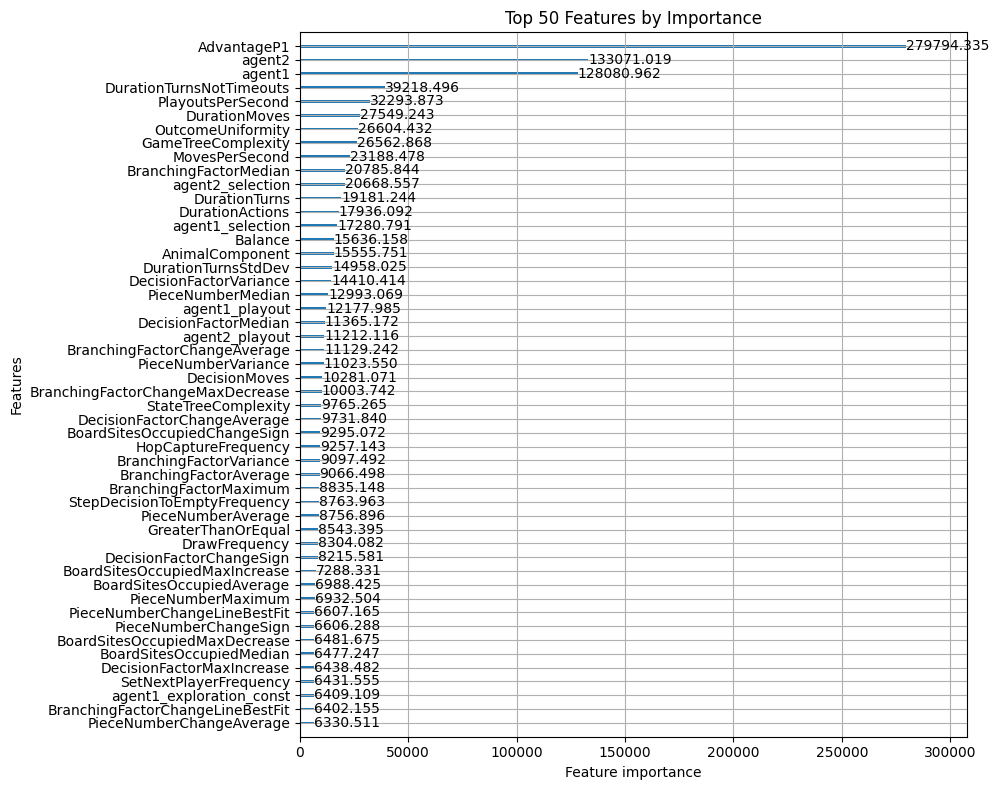

Fold 1 - RMSE: 0.4298735227595118
Fold 2


[100]	valid_0's rmse: 0.506341


[200]	valid_0's rmse: 0.490788


[300]	valid_0's rmse: 0.482077


[400]	valid_0's rmse: 0.476848


[500]	valid_0's rmse: 0.473276


[600]	valid_0's rmse: 0.469296


[700]	valid_0's rmse: 0.466943


[800]	valid_0's rmse: 0.464896


[900]	valid_0's rmse: 0.463125


[1000]	valid_0's rmse: 0.461706


[1100]	valid_0's rmse: 0.460794


[1200]	valid_0's rmse: 0.459726


[1300]	valid_0's rmse: 0.459297


[1400]	valid_0's rmse: 0.458498


[1500]	valid_0's rmse: 0.457903


[1600]	valid_0's rmse: 0.457174


[1700]	valid_0's rmse: 0.456577


[1800]	valid_0's rmse: 0.455981


[1900]	valid_0's rmse: 0.455449


[2000]	valid_0's rmse: 0.455009


[2100]	valid_0's rmse: 0.4546


[2200]	valid_0's rmse: 0.454381


[2300]	valid_0's rmse: 0.454008


[2400]	valid_0's rmse: 0.453523


[2500]	valid_0's rmse: 0.453203


[2600]	valid_0's rmse: 0.452783


[2700]	valid_0's rmse: 0.452431


[2800]	valid_0's rmse: 0.452148


[2900]	valid_0's rmse: 0.451852


[3000]	valid_0's rmse: 0.451466


[3100]	valid_0's rmse: 0.451185


[3200]	valid_0's rmse: 0.45102


[3300]	valid_0's rmse: 0.450779


[3400]	valid_0's rmse: 0.450752


[3500]	valid_0's rmse: 0.450497


[3600]	valid_0's rmse: 0.450282


[3700]	valid_0's rmse: 0.450156


[3800]	valid_0's rmse: 0.450022


[3900]	valid_0's rmse: 0.44993


[4000]	valid_0's rmse: 0.449769


[4100]	valid_0's rmse: 0.44955


[4200]	valid_0's rmse: 0.449465


[4300]	valid_0's rmse: 0.449427


[4400]	valid_0's rmse: 0.449307


[4500]	valid_0's rmse: 0.449291


[4600]	valid_0's rmse: 0.449212


[4700]	valid_0's rmse: 0.449072


[4800]	valid_0's rmse: 0.449128


[4900]	valid_0's rmse: 0.449001


[5000]	valid_0's rmse: 0.448874


[5100]	valid_0's rmse: 0.448819


[5200]	valid_0's rmse: 0.448682


[5300]	valid_0's rmse: 0.44871


[5400]	valid_0's rmse: 0.448654


[5500]	valid_0's rmse: 0.448648


[5600]	valid_0's rmse: 0.448595


[5700]	valid_0's rmse: 0.44848


[5800]	valid_0's rmse: 0.448422


[5900]	valid_0's rmse: 0.448387


[6000]	valid_0's rmse: 0.448326


[6100]	valid_0's rmse: 0.448287


[6200]	valid_0's rmse: 0.448319


[6300]	valid_0's rmse: 0.448327


[6400]	valid_0's rmse: 0.448244


[6500]	valid_0's rmse: 0.448127


[6600]	valid_0's rmse: 0.448145


[6700]	valid_0's rmse: 0.448048


[6800]	valid_0's rmse: 0.447929


[6900]	valid_0's rmse: 0.447902


[7000]	valid_0's rmse: 0.447811


[7100]	valid_0's rmse: 0.447806


[7200]	valid_0's rmse: 0.447783


[7300]	valid_0's rmse: 0.447766


[7400]	valid_0's rmse: 0.447781


[7500]	valid_0's rmse: 0.447721


[7600]	valid_0's rmse: 0.447673


[7700]	valid_0's rmse: 0.447737


[7800]	valid_0's rmse: 0.447663


[7900]	valid_0's rmse: 0.447611


[8000]	valid_0's rmse: 0.447553


[8100]	valid_0's rmse: 0.447532


[8200]	valid_0's rmse: 0.447468


[8300]	valid_0's rmse: 0.44742


[8400]	valid_0's rmse: 0.447326


[8500]	valid_0's rmse: 0.447291


[8600]	valid_0's rmse: 0.44729


[8700]	valid_0's rmse: 0.447214


[8800]	valid_0's rmse: 0.447125


[8900]	valid_0's rmse: 0.447105


[9000]	valid_0's rmse: 0.447018


[9100]	valid_0's rmse: 0.447


[9200]	valid_0's rmse: 0.446936


[9300]	valid_0's rmse: 0.446903


[9400]	valid_0's rmse: 0.446922


[9500]	valid_0's rmse: 0.446861


[9600]	valid_0's rmse: 0.446906


[9700]	valid_0's rmse: 0.446876


[9800]	valid_0's rmse: 0.446838


[9900]	valid_0's rmse: 0.446848


[10000]	valid_0's rmse: 0.446844


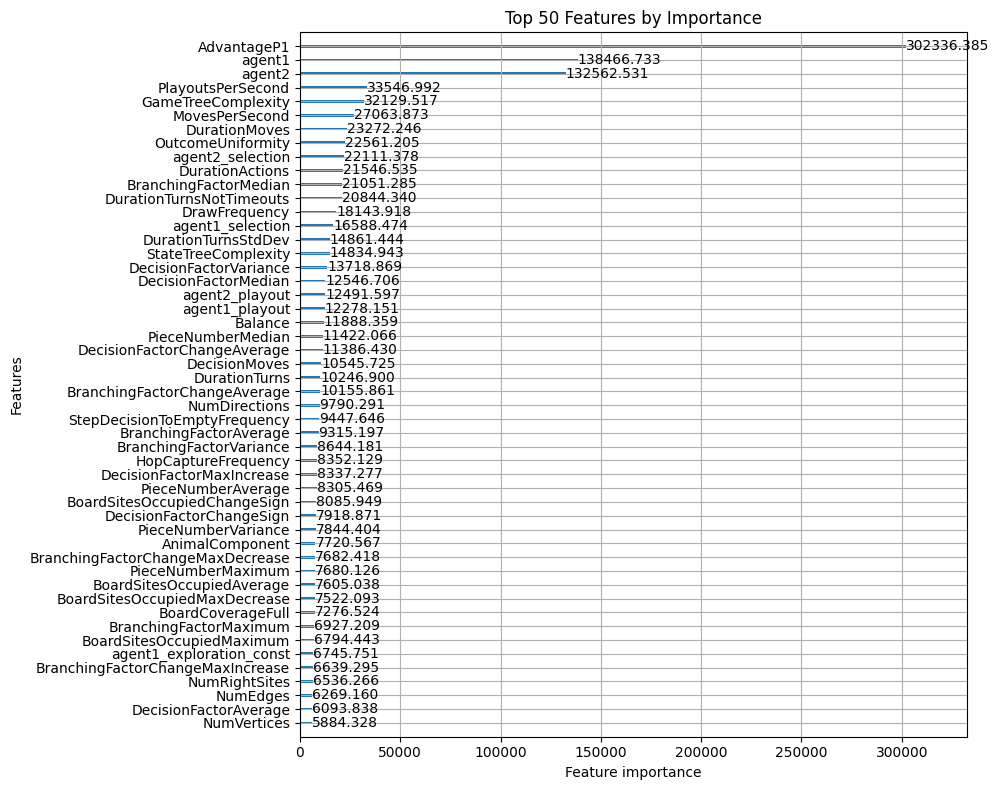

Fold 2 - RMSE: 0.44618946983675384
Fold 3


[100]	valid_0's rmse: 0.514492


[200]	valid_0's rmse: 0.487512


[300]	valid_0's rmse: 0.477941


[400]	valid_0's rmse: 0.472039


[500]	valid_0's rmse: 0.467796


[600]	valid_0's rmse: 0.465274


[700]	valid_0's rmse: 0.462461


[800]	valid_0's rmse: 0.459762


[900]	valid_0's rmse: 0.458169


[1000]	valid_0's rmse: 0.456492


[1100]	valid_0's rmse: 0.455342


[1200]	valid_0's rmse: 0.454191


[1300]	valid_0's rmse: 0.453152


[1400]	valid_0's rmse: 0.452236


[1500]	valid_0's rmse: 0.451326


[1600]	valid_0's rmse: 0.45079


[1700]	valid_0's rmse: 0.450353


[1800]	valid_0's rmse: 0.449747


[1900]	valid_0's rmse: 0.449306


[2000]	valid_0's rmse: 0.448926


[2100]	valid_0's rmse: 0.448547


[2200]	valid_0's rmse: 0.448168


[2300]	valid_0's rmse: 0.447909


[2400]	valid_0's rmse: 0.44768


[2500]	valid_0's rmse: 0.447321


[2600]	valid_0's rmse: 0.447098


[2700]	valid_0's rmse: 0.446928


[2800]	valid_0's rmse: 0.446664


[2900]	valid_0's rmse: 0.446448


[3000]	valid_0's rmse: 0.446235


[3100]	valid_0's rmse: 0.446086


[3200]	valid_0's rmse: 0.446


[3300]	valid_0's rmse: 0.445814


[3400]	valid_0's rmse: 0.445514


[3500]	valid_0's rmse: 0.445473


[3600]	valid_0's rmse: 0.445378


[3700]	valid_0's rmse: 0.445233


[3800]	valid_0's rmse: 0.445061


[3900]	valid_0's rmse: 0.444902


[4000]	valid_0's rmse: 0.444735


[4100]	valid_0's rmse: 0.444504


[4200]	valid_0's rmse: 0.444311


[4300]	valid_0's rmse: 0.444332


[4400]	valid_0's rmse: 0.444112


[4500]	valid_0's rmse: 0.44397


[4600]	valid_0's rmse: 0.443955


[4700]	valid_0's rmse: 0.443799


[4800]	valid_0's rmse: 0.443808


[4900]	valid_0's rmse: 0.4437


[5000]	valid_0's rmse: 0.44358


[5100]	valid_0's rmse: 0.443513


[5200]	valid_0's rmse: 0.443379


[5300]	valid_0's rmse: 0.443267


[5400]	valid_0's rmse: 0.4432


[5500]	valid_0's rmse: 0.443045


[5600]	valid_0's rmse: 0.442948


[5700]	valid_0's rmse: 0.44287


[5800]	valid_0's rmse: 0.442871


[5900]	valid_0's rmse: 0.442768


[6000]	valid_0's rmse: 0.442746


[6100]	valid_0's rmse: 0.442714


[6200]	valid_0's rmse: 0.442656


[6300]	valid_0's rmse: 0.442586


[6400]	valid_0's rmse: 0.442504


[6500]	valid_0's rmse: 0.442317


[6600]	valid_0's rmse: 0.442354


[6700]	valid_0's rmse: 0.442335


[6800]	valid_0's rmse: 0.442277


[6900]	valid_0's rmse: 0.442201


[7000]	valid_0's rmse: 0.442106


[7100]	valid_0's rmse: 0.442135


[7200]	valid_0's rmse: 0.442149


[7300]	valid_0's rmse: 0.442105


[7400]	valid_0's rmse: 0.442033


[7500]	valid_0's rmse: 0.441961


[7600]	valid_0's rmse: 0.441933


[7700]	valid_0's rmse: 0.4419


[7800]	valid_0's rmse: 0.441836


[7900]	valid_0's rmse: 0.441803


[8000]	valid_0's rmse: 0.441768


[8100]	valid_0's rmse: 0.441745


[8200]	valid_0's rmse: 0.441748


[8300]	valid_0's rmse: 0.441734


[8400]	valid_0's rmse: 0.441724


[8500]	valid_0's rmse: 0.441691


[8600]	valid_0's rmse: 0.441673


[8700]	valid_0's rmse: 0.4416


[8800]	valid_0's rmse: 0.441575


[8900]	valid_0's rmse: 0.441582


[9000]	valid_0's rmse: 0.441528


[9100]	valid_0's rmse: 0.441567


[9200]	valid_0's rmse: 0.441545


[9300]	valid_0's rmse: 0.441552


[9400]	valid_0's rmse: 0.441588


[9500]	valid_0's rmse: 0.441571


[9600]	valid_0's rmse: 0.441499


[9700]	valid_0's rmse: 0.441486


[9800]	valid_0's rmse: 0.441488


[9900]	valid_0's rmse: 0.441486


[10000]	valid_0's rmse: 0.441461


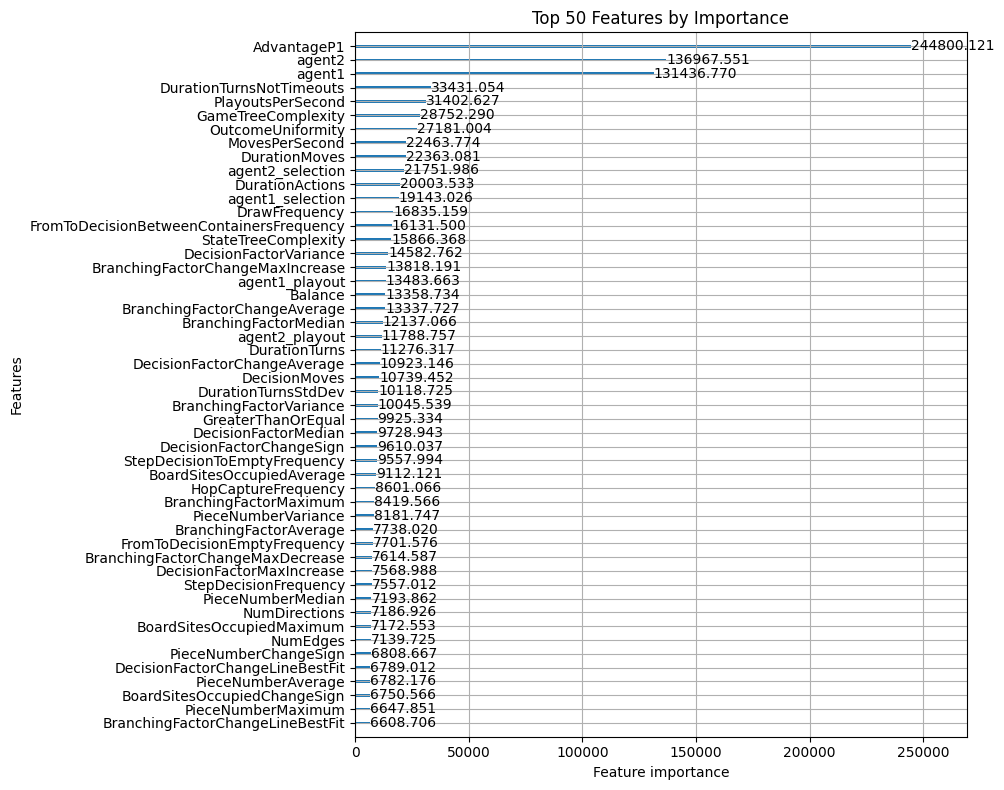

Fold 3 - RMSE: 0.44068245046631804
Fold 4


[100]	valid_0's rmse: 0.519222


[200]	valid_0's rmse: 0.495392


[300]	valid_0's rmse: 0.483659


[400]	valid_0's rmse: 0.476089


[500]	valid_0's rmse: 0.470417


[600]	valid_0's rmse: 0.46552


[700]	valid_0's rmse: 0.462894


[800]	valid_0's rmse: 0.460285


[900]	valid_0's rmse: 0.458711


[1000]	valid_0's rmse: 0.456945


[1100]	valid_0's rmse: 0.455692


[1200]	valid_0's rmse: 0.453936


[1300]	valid_0's rmse: 0.452941


[1400]	valid_0's rmse: 0.451935


[1500]	valid_0's rmse: 0.45097


[1600]	valid_0's rmse: 0.450204


[1700]	valid_0's rmse: 0.44961


[1800]	valid_0's rmse: 0.448968


[1900]	valid_0's rmse: 0.448297


[2000]	valid_0's rmse: 0.447837


[2100]	valid_0's rmse: 0.4473


[2200]	valid_0's rmse: 0.446842


[2300]	valid_0's rmse: 0.446516


[2400]	valid_0's rmse: 0.446164


[2500]	valid_0's rmse: 0.445954


[2600]	valid_0's rmse: 0.445552


[2700]	valid_0's rmse: 0.445301


[2800]	valid_0's rmse: 0.444997


[2900]	valid_0's rmse: 0.444872


[3000]	valid_0's rmse: 0.444575


[3100]	valid_0's rmse: 0.444304


[3200]	valid_0's rmse: 0.444107


[3300]	valid_0's rmse: 0.443857


[3400]	valid_0's rmse: 0.443733


[3500]	valid_0's rmse: 0.443457


[3600]	valid_0's rmse: 0.443226


[3700]	valid_0's rmse: 0.443157


[3800]	valid_0's rmse: 0.443019


[3900]	valid_0's rmse: 0.442865


[4000]	valid_0's rmse: 0.4427


[4100]	valid_0's rmse: 0.442528


[4200]	valid_0's rmse: 0.442411


[4300]	valid_0's rmse: 0.44227


[4400]	valid_0's rmse: 0.442194


[4500]	valid_0's rmse: 0.442082


[4600]	valid_0's rmse: 0.441963


[4700]	valid_0's rmse: 0.441808


[4800]	valid_0's rmse: 0.441646


[4900]	valid_0's rmse: 0.441526


[5000]	valid_0's rmse: 0.441429


[5100]	valid_0's rmse: 0.441295


[5200]	valid_0's rmse: 0.441213


[5300]	valid_0's rmse: 0.44116


[5400]	valid_0's rmse: 0.441061


[5500]	valid_0's rmse: 0.441076


[5600]	valid_0's rmse: 0.440985


[5700]	valid_0's rmse: 0.440929


[5800]	valid_0's rmse: 0.440849


[5900]	valid_0's rmse: 0.440806


[6000]	valid_0's rmse: 0.440613


[6100]	valid_0's rmse: 0.440528


[6200]	valid_0's rmse: 0.44046


[6300]	valid_0's rmse: 0.440369


[6400]	valid_0's rmse: 0.440317


[6500]	valid_0's rmse: 0.440278


[6600]	valid_0's rmse: 0.44019


[6700]	valid_0's rmse: 0.440135


[6800]	valid_0's rmse: 0.440133


[6900]	valid_0's rmse: 0.440029


[7000]	valid_0's rmse: 0.439904


[7100]	valid_0's rmse: 0.439768


[7200]	valid_0's rmse: 0.439682


[7300]	valid_0's rmse: 0.439613


[7400]	valid_0's rmse: 0.439633


[7500]	valid_0's rmse: 0.439682


[7600]	valid_0's rmse: 0.439697


[7700]	valid_0's rmse: 0.439635


[7800]	valid_0's rmse: 0.439657


[7900]	valid_0's rmse: 0.43958


[8000]	valid_0's rmse: 0.439563


[8100]	valid_0's rmse: 0.439504


[8200]	valid_0's rmse: 0.43948


[8300]	valid_0's rmse: 0.439486


[8400]	valid_0's rmse: 0.439471


[8500]	valid_0's rmse: 0.439477


[8600]	valid_0's rmse: 0.439392


[8700]	valid_0's rmse: 0.439359


[8800]	valid_0's rmse: 0.439321


[8900]	valid_0's rmse: 0.439272


[9000]	valid_0's rmse: 0.439251


[9100]	valid_0's rmse: 0.439165


[9200]	valid_0's rmse: 0.439171


[9300]	valid_0's rmse: 0.439209


[9400]	valid_0's rmse: 0.43921


[9500]	valid_0's rmse: 0.439183


[9600]	valid_0's rmse: 0.439176


[9700]	valid_0's rmse: 0.439125


[9800]	valid_0's rmse: 0.439099


[9900]	valid_0's rmse: 0.439091


[10000]	valid_0's rmse: 0.439035


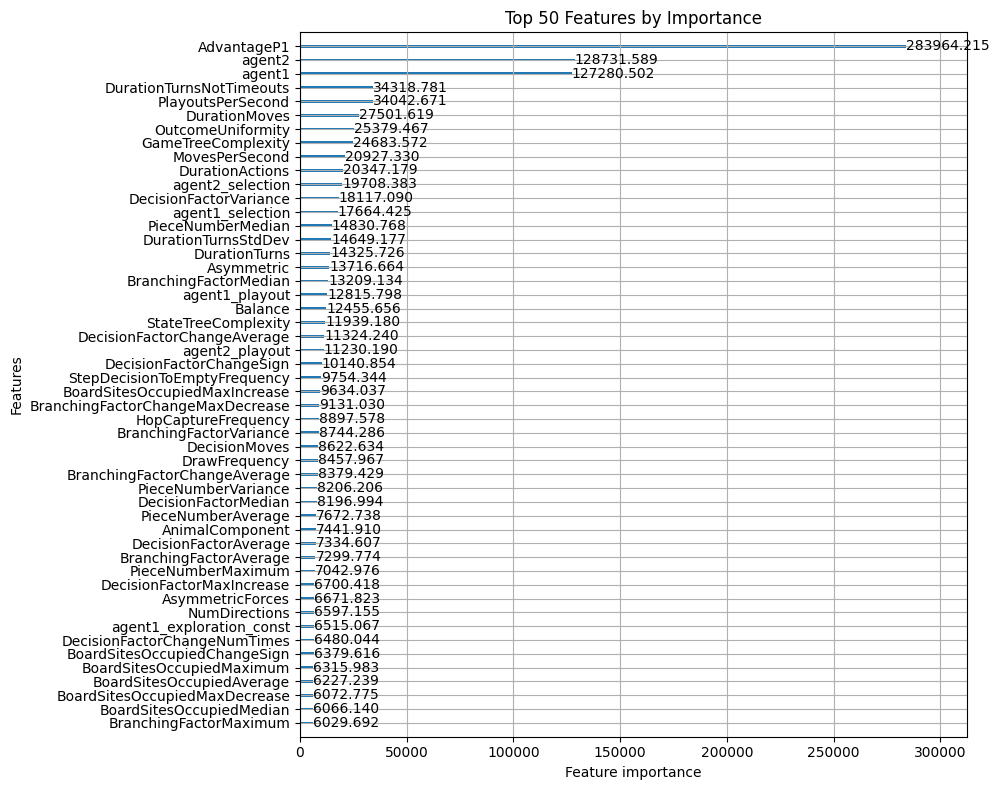

Fold 4 - RMSE: 0.4381611318736827
Fold 5


[100]	valid_0's rmse: 0.489511


[200]	valid_0's rmse: 0.466853


[300]	valid_0's rmse: 0.455636


[400]	valid_0's rmse: 0.446792


[500]	valid_0's rmse: 0.439838


[600]	valid_0's rmse: 0.435188


[700]	valid_0's rmse: 0.431818


[800]	valid_0's rmse: 0.428779


[900]	valid_0's rmse: 0.426194


[1000]	valid_0's rmse: 0.42465


[1100]	valid_0's rmse: 0.422756


[1200]	valid_0's rmse: 0.421341


[1300]	valid_0's rmse: 0.420133


[1400]	valid_0's rmse: 0.418968


[1500]	valid_0's rmse: 0.418154


[1600]	valid_0's rmse: 0.417356


[1700]	valid_0's rmse: 0.416718


[1800]	valid_0's rmse: 0.416011


[1900]	valid_0's rmse: 0.415433


[2000]	valid_0's rmse: 0.414952


[2100]	valid_0's rmse: 0.414485


[2200]	valid_0's rmse: 0.414036


[2300]	valid_0's rmse: 0.413619


[2400]	valid_0's rmse: 0.413235


[2500]	valid_0's rmse: 0.412748


[2600]	valid_0's rmse: 0.412468


[2700]	valid_0's rmse: 0.412163


[2800]	valid_0's rmse: 0.411957


[2900]	valid_0's rmse: 0.411684


[3000]	valid_0's rmse: 0.411348


[3100]	valid_0's rmse: 0.411107


[3200]	valid_0's rmse: 0.410854


[3300]	valid_0's rmse: 0.410607


[3400]	valid_0's rmse: 0.410579


[3500]	valid_0's rmse: 0.410322


[3600]	valid_0's rmse: 0.410174


[3700]	valid_0's rmse: 0.40994


[3800]	valid_0's rmse: 0.409755


[3900]	valid_0's rmse: 0.409462


[4000]	valid_0's rmse: 0.409282


[4100]	valid_0's rmse: 0.409229


[4200]	valid_0's rmse: 0.409101


[4300]	valid_0's rmse: 0.409027


[4400]	valid_0's rmse: 0.40898


[4500]	valid_0's rmse: 0.408946


[4600]	valid_0's rmse: 0.408841


[4700]	valid_0's rmse: 0.408697


[4800]	valid_0's rmse: 0.408647


[4900]	valid_0's rmse: 0.408615


[5000]	valid_0's rmse: 0.408511


[5100]	valid_0's rmse: 0.408435


[5200]	valid_0's rmse: 0.408335


[5300]	valid_0's rmse: 0.408272


[5400]	valid_0's rmse: 0.408229


[5500]	valid_0's rmse: 0.408133


[5600]	valid_0's rmse: 0.408103


[5700]	valid_0's rmse: 0.408071


[5800]	valid_0's rmse: 0.408008


[5900]	valid_0's rmse: 0.407958


[6000]	valid_0's rmse: 0.408016


[6100]	valid_0's rmse: 0.407998


[6200]	valid_0's rmse: 0.40803


[6300]	valid_0's rmse: 0.407957


[6400]	valid_0's rmse: 0.407876


[6500]	valid_0's rmse: 0.407799


[6600]	valid_0's rmse: 0.407778


[6700]	valid_0's rmse: 0.407728


[6800]	valid_0's rmse: 0.407624


[6900]	valid_0's rmse: 0.407582


[7000]	valid_0's rmse: 0.407508


[7100]	valid_0's rmse: 0.40751


[7200]	valid_0's rmse: 0.407533


[7300]	valid_0's rmse: 0.407541


[7400]	valid_0's rmse: 0.407487


[7500]	valid_0's rmse: 0.407456


[7600]	valid_0's rmse: 0.407387


[7700]	valid_0's rmse: 0.407413


[7800]	valid_0's rmse: 0.407415


[7900]	valid_0's rmse: 0.407337


[8000]	valid_0's rmse: 0.40737


[8100]	valid_0's rmse: 0.407355


[8200]	valid_0's rmse: 0.40736


[8300]	valid_0's rmse: 0.407354


[8400]	valid_0's rmse: 0.407386


[8500]	valid_0's rmse: 0.407389


[8600]	valid_0's rmse: 0.407356


[8700]	valid_0's rmse: 0.407383


[8800]	valid_0's rmse: 0.407363


[8900]	valid_0's rmse: 0.407341


[9000]	valid_0's rmse: 0.407324


[9100]	valid_0's rmse: 0.407294


[9200]	valid_0's rmse: 0.407298


[9300]	valid_0's rmse: 0.407254


[9400]	valid_0's rmse: 0.407224


[9500]	valid_0's rmse: 0.40721


[9600]	valid_0's rmse: 0.407201


[9700]	valid_0's rmse: 0.407167


[9800]	valid_0's rmse: 0.407153


[9900]	valid_0's rmse: 0.407161


[10000]	valid_0's rmse: 0.407161


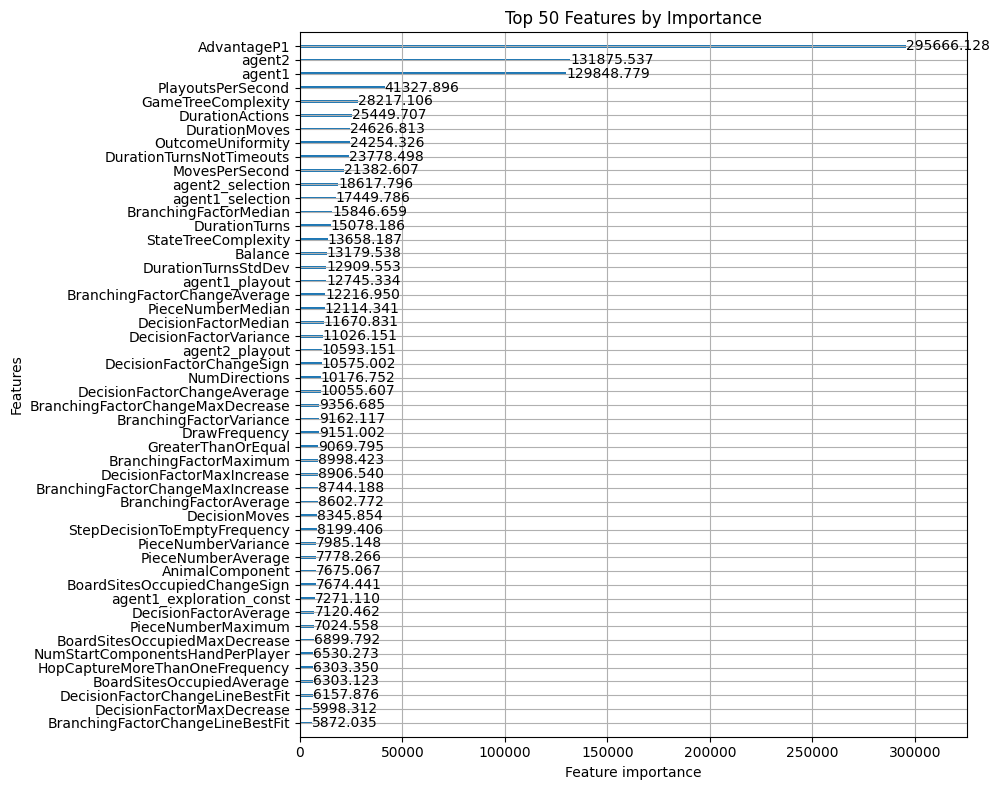

Fold 5 - RMSE: 0.40671083131140573
List of oof scores: [0.4298735227595118, 0.44618946983675384, 0.44068245046631804, 0.4381611318736827, 0.40671083131140573]
Average oof score: 0.4323234812495344


In [11]:
# call the function
trained_models1, oof1, oof_scores1, importance_df1 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split1,
)
# save oof predictions
oof1.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv1.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.478087


[200]	valid_0's rmse: 0.458902


[300]	valid_0's rmse: 0.44837


[400]	valid_0's rmse: 0.442134


[500]	valid_0's rmse: 0.437641


[600]	valid_0's rmse: 0.434916


[700]	valid_0's rmse: 0.431754


[800]	valid_0's rmse: 0.430114


[900]	valid_0's rmse: 0.428494


[1000]	valid_0's rmse: 0.426792


[1100]	valid_0's rmse: 0.425832


[1200]	valid_0's rmse: 0.424865


[1300]	valid_0's rmse: 0.423806


[1400]	valid_0's rmse: 0.423037


[1500]	valid_0's rmse: 0.422534


[1600]	valid_0's rmse: 0.421913


[1700]	valid_0's rmse: 0.421318


[1800]	valid_0's rmse: 0.420875


[1900]	valid_0's rmse: 0.420358


[2000]	valid_0's rmse: 0.419824


[2100]	valid_0's rmse: 0.419292


[2200]	valid_0's rmse: 0.418841


[2300]	valid_0's rmse: 0.418481


[2400]	valid_0's rmse: 0.418231


[2500]	valid_0's rmse: 0.417948


[2600]	valid_0's rmse: 0.417498


[2700]	valid_0's rmse: 0.417119


[2800]	valid_0's rmse: 0.416805


[2900]	valid_0's rmse: 0.416479


[3000]	valid_0's rmse: 0.416357


[3100]	valid_0's rmse: 0.416022


[3200]	valid_0's rmse: 0.415734


[3300]	valid_0's rmse: 0.415584


[3400]	valid_0's rmse: 0.415418


[3500]	valid_0's rmse: 0.415336


[3600]	valid_0's rmse: 0.415106


[3700]	valid_0's rmse: 0.414961


[3800]	valid_0's rmse: 0.414784


[3900]	valid_0's rmse: 0.414606


[4000]	valid_0's rmse: 0.41456


[4100]	valid_0's rmse: 0.414407


[4200]	valid_0's rmse: 0.414201


[4300]	valid_0's rmse: 0.414144


[4400]	valid_0's rmse: 0.414016


[4500]	valid_0's rmse: 0.413744


[4600]	valid_0's rmse: 0.4135


[4700]	valid_0's rmse: 0.413413


[4800]	valid_0's rmse: 0.413272


[4900]	valid_0's rmse: 0.413102


[5000]	valid_0's rmse: 0.412995


[5100]	valid_0's rmse: 0.4129


[5200]	valid_0's rmse: 0.412882


[5300]	valid_0's rmse: 0.412853


[5400]	valid_0's rmse: 0.412823


[5500]	valid_0's rmse: 0.412796


[5600]	valid_0's rmse: 0.412745


[5700]	valid_0's rmse: 0.412679


[5800]	valid_0's rmse: 0.412579


[5900]	valid_0's rmse: 0.412529


[6000]	valid_0's rmse: 0.412505


[6100]	valid_0's rmse: 0.412388


[6200]	valid_0's rmse: 0.412266


[6300]	valid_0's rmse: 0.41219


[6400]	valid_0's rmse: 0.412122


[6500]	valid_0's rmse: 0.412064


[6600]	valid_0's rmse: 0.412054


[6700]	valid_0's rmse: 0.412018


[6800]	valid_0's rmse: 0.411967


[6900]	valid_0's rmse: 0.412027


[7000]	valid_0's rmse: 0.411941


[7100]	valid_0's rmse: 0.411846


[7200]	valid_0's rmse: 0.411722


[7300]	valid_0's rmse: 0.41165


[7400]	valid_0's rmse: 0.411576


[7500]	valid_0's rmse: 0.411522


[7600]	valid_0's rmse: 0.411525


[7700]	valid_0's rmse: 0.411452


[7800]	valid_0's rmse: 0.411439


[7900]	valid_0's rmse: 0.411419


[8000]	valid_0's rmse: 0.411376


[8100]	valid_0's rmse: 0.411389


[8200]	valid_0's rmse: 0.411352


[8300]	valid_0's rmse: 0.411375


[8400]	valid_0's rmse: 0.411321


[8500]	valid_0's rmse: 0.411228


[8600]	valid_0's rmse: 0.411224


[8700]	valid_0's rmse: 0.411164


[8800]	valid_0's rmse: 0.411138


[8900]	valid_0's rmse: 0.4111


[9000]	valid_0's rmse: 0.411142


[9100]	valid_0's rmse: 0.41114


[9200]	valid_0's rmse: 0.411134


[9300]	valid_0's rmse: 0.411084


[9400]	valid_0's rmse: 0.411079


[9500]	valid_0's rmse: 0.411038


[9600]	valid_0's rmse: 0.411068


[9700]	valid_0's rmse: 0.41108


[9800]	valid_0's rmse: 0.411107


[9900]	valid_0's rmse: 0.411086


[10000]	valid_0's rmse: 0.411082


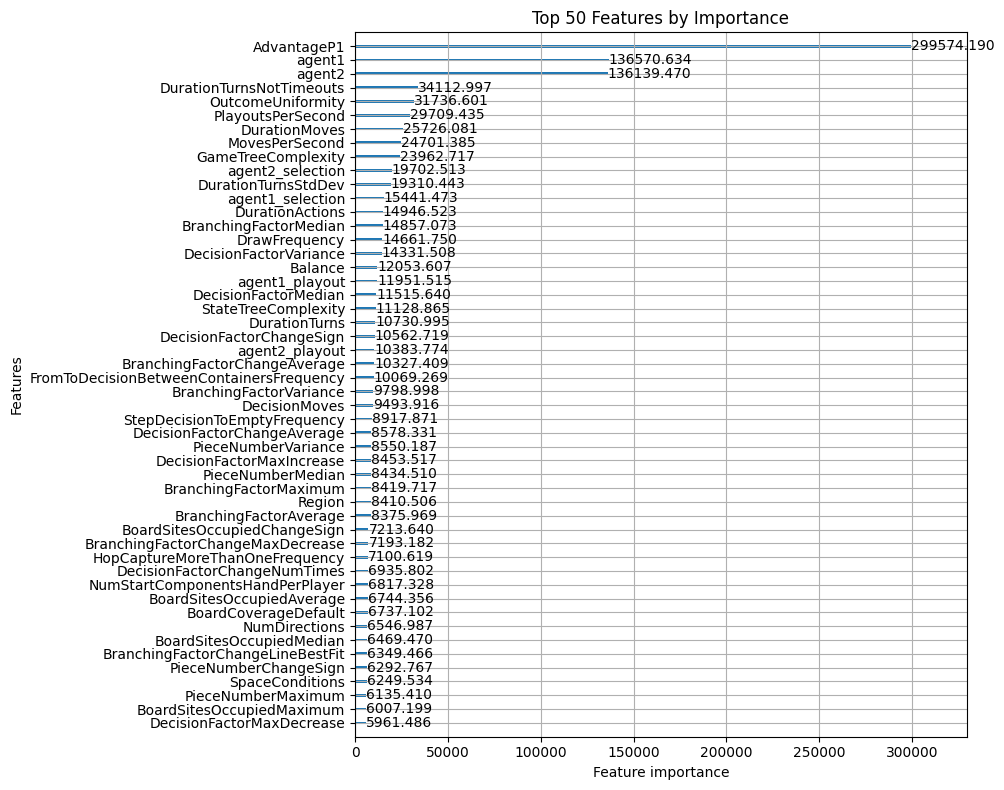

Fold 1 - RMSE: 0.41065420579768597
Fold 2


[100]	valid_0's rmse: 0.459448


[200]	valid_0's rmse: 0.438511


[300]	valid_0's rmse: 0.430198


[400]	valid_0's rmse: 0.425184


[500]	valid_0's rmse: 0.420839


[600]	valid_0's rmse: 0.417954


[700]	valid_0's rmse: 0.415806


[800]	valid_0's rmse: 0.414376


[900]	valid_0's rmse: 0.412842


[1000]	valid_0's rmse: 0.411612


[1100]	valid_0's rmse: 0.410637


[1200]	valid_0's rmse: 0.409739


[1300]	valid_0's rmse: 0.409004


[1400]	valid_0's rmse: 0.408134


[1500]	valid_0's rmse: 0.407511


[1600]	valid_0's rmse: 0.40702


[1700]	valid_0's rmse: 0.406596


[1800]	valid_0's rmse: 0.406118


[1900]	valid_0's rmse: 0.405685


[2000]	valid_0's rmse: 0.405376


[2100]	valid_0's rmse: 0.405074


[2200]	valid_0's rmse: 0.404771


[2300]	valid_0's rmse: 0.404569


[2400]	valid_0's rmse: 0.404399


[2500]	valid_0's rmse: 0.404044


[2600]	valid_0's rmse: 0.403896


[2700]	valid_0's rmse: 0.403708


[2800]	valid_0's rmse: 0.40367


[2900]	valid_0's rmse: 0.403581


[3000]	valid_0's rmse: 0.403459


[3100]	valid_0's rmse: 0.403319


[3200]	valid_0's rmse: 0.403119


[3300]	valid_0's rmse: 0.403041


[3400]	valid_0's rmse: 0.40291


[3500]	valid_0's rmse: 0.402791


[3600]	valid_0's rmse: 0.402599


[3700]	valid_0's rmse: 0.402586


[3800]	valid_0's rmse: 0.402479


[3900]	valid_0's rmse: 0.402417


[4000]	valid_0's rmse: 0.402289


[4100]	valid_0's rmse: 0.402228


[4200]	valid_0's rmse: 0.402175


[4300]	valid_0's rmse: 0.402086


[4400]	valid_0's rmse: 0.402007


[4500]	valid_0's rmse: 0.40204


[4600]	valid_0's rmse: 0.401995


[4700]	valid_0's rmse: 0.402062


[4800]	valid_0's rmse: 0.401988


[4900]	valid_0's rmse: 0.40198


[5000]	valid_0's rmse: 0.401885


[5100]	valid_0's rmse: 0.401832


[5200]	valid_0's rmse: 0.401737


[5300]	valid_0's rmse: 0.40169


[5400]	valid_0's rmse: 0.401651


[5500]	valid_0's rmse: 0.401724


[5600]	valid_0's rmse: 0.401704


[5700]	valid_0's rmse: 0.401648


[5800]	valid_0's rmse: 0.401644


[5900]	valid_0's rmse: 0.401731


[6000]	valid_0's rmse: 0.401672


[6100]	valid_0's rmse: 0.401665


[6200]	valid_0's rmse: 0.40169


[6300]	valid_0's rmse: 0.401649


[6400]	valid_0's rmse: 0.401605


[6500]	valid_0's rmse: 0.401635


[6600]	valid_0's rmse: 0.401626


[6700]	valid_0's rmse: 0.401567


[6800]	valid_0's rmse: 0.401551


[6900]	valid_0's rmse: 0.401474


[7000]	valid_0's rmse: 0.401434


[7100]	valid_0's rmse: 0.401412


[7200]	valid_0's rmse: 0.401461


[7300]	valid_0's rmse: 0.401438


[7400]	valid_0's rmse: 0.401452


[7500]	valid_0's rmse: 0.40142


[7600]	valid_0's rmse: 0.401417


[7700]	valid_0's rmse: 0.401437


[7800]	valid_0's rmse: 0.401376


[7900]	valid_0's rmse: 0.401332


[8000]	valid_0's rmse: 0.401357


[8100]	valid_0's rmse: 0.401322


[8200]	valid_0's rmse: 0.40126


[8300]	valid_0's rmse: 0.401301


[8400]	valid_0's rmse: 0.401286


[8500]	valid_0's rmse: 0.401282


[8600]	valid_0's rmse: 0.401406


[8700]	valid_0's rmse: 0.4014


[8800]	valid_0's rmse: 0.401394


[8900]	valid_0's rmse: 0.401429


[9000]	valid_0's rmse: 0.401402


[9100]	valid_0's rmse: 0.401383


[9200]	valid_0's rmse: 0.40133


[9300]	valid_0's rmse: 0.40137


[9400]	valid_0's rmse: 0.401381


[9500]	valid_0's rmse: 0.401417


[9600]	valid_0's rmse: 0.40143


[9700]	valid_0's rmse: 0.401487


[9800]	valid_0's rmse: 0.401545


[9900]	valid_0's rmse: 0.401542


[10000]	valid_0's rmse: 0.401562


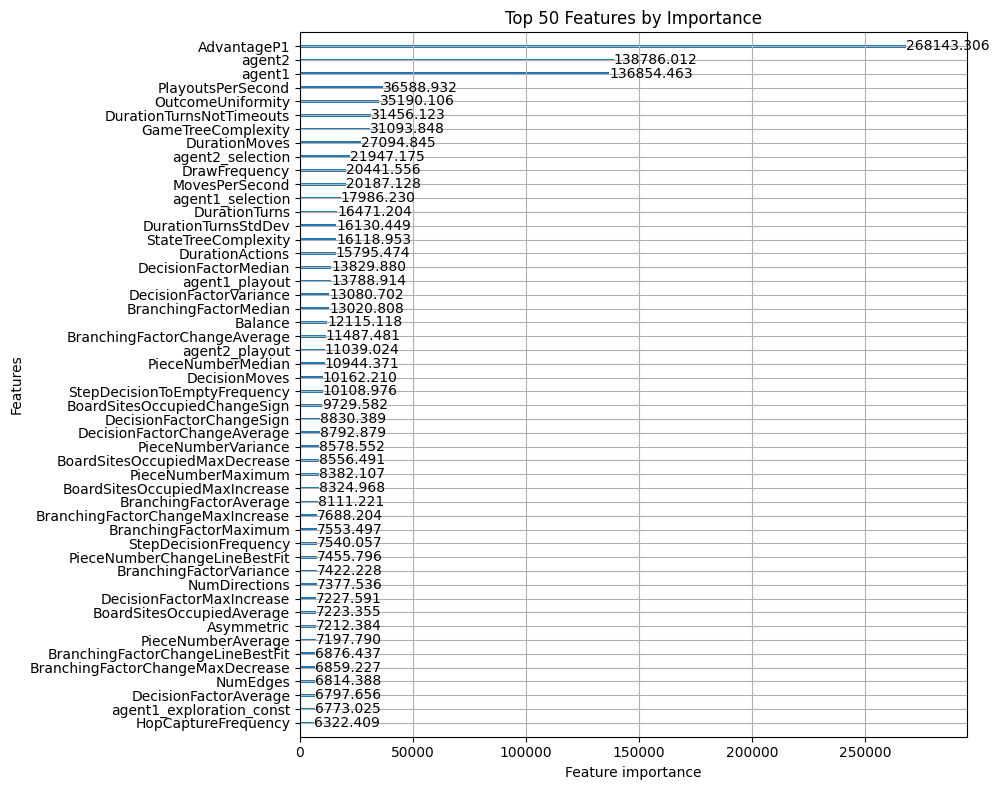

Fold 2 - RMSE: 0.40078199410353343
Fold 3


[100]	valid_0's rmse: 0.524562


[200]	valid_0's rmse: 0.497237


[300]	valid_0's rmse: 0.484684


[400]	valid_0's rmse: 0.476275


[500]	valid_0's rmse: 0.469484


[600]	valid_0's rmse: 0.465074


[700]	valid_0's rmse: 0.461547


[800]	valid_0's rmse: 0.458641


[900]	valid_0's rmse: 0.456484


[1000]	valid_0's rmse: 0.454467


[1100]	valid_0's rmse: 0.452759


[1200]	valid_0's rmse: 0.451462


[1300]	valid_0's rmse: 0.450144


[1400]	valid_0's rmse: 0.448872


[1500]	valid_0's rmse: 0.447858


[1600]	valid_0's rmse: 0.446846


[1700]	valid_0's rmse: 0.446026


[1800]	valid_0's rmse: 0.445265


[1900]	valid_0's rmse: 0.444594


[2000]	valid_0's rmse: 0.443878


[2100]	valid_0's rmse: 0.443454


[2200]	valid_0's rmse: 0.442988


[2300]	valid_0's rmse: 0.442459


[2400]	valid_0's rmse: 0.442024


[2500]	valid_0's rmse: 0.441664


[2600]	valid_0's rmse: 0.441245


[2700]	valid_0's rmse: 0.440888


[2800]	valid_0's rmse: 0.44058


[2900]	valid_0's rmse: 0.440304


[3000]	valid_0's rmse: 0.440013


[3100]	valid_0's rmse: 0.439763


[3200]	valid_0's rmse: 0.439527


[3300]	valid_0's rmse: 0.439293


[3400]	valid_0's rmse: 0.439125


[3500]	valid_0's rmse: 0.438906


[3600]	valid_0's rmse: 0.438692


[3700]	valid_0's rmse: 0.438478


[3800]	valid_0's rmse: 0.438252


[3900]	valid_0's rmse: 0.437988


[4000]	valid_0's rmse: 0.437805


[4100]	valid_0's rmse: 0.437609


[4200]	valid_0's rmse: 0.437593


[4300]	valid_0's rmse: 0.437412


[4400]	valid_0's rmse: 0.437262


[4500]	valid_0's rmse: 0.437142


[4600]	valid_0's rmse: 0.436958


[4700]	valid_0's rmse: 0.436842


[4800]	valid_0's rmse: 0.436705


[4900]	valid_0's rmse: 0.436524


[5000]	valid_0's rmse: 0.43638


[5100]	valid_0's rmse: 0.436302


[5200]	valid_0's rmse: 0.436137


[5300]	valid_0's rmse: 0.436117


[5400]	valid_0's rmse: 0.436017


[5500]	valid_0's rmse: 0.435873


[5600]	valid_0's rmse: 0.435822


[5700]	valid_0's rmse: 0.435674


[5800]	valid_0's rmse: 0.435576


[5900]	valid_0's rmse: 0.435404


[6000]	valid_0's rmse: 0.435375


[6100]	valid_0's rmse: 0.435315


[6200]	valid_0's rmse: 0.43524


[6300]	valid_0's rmse: 0.435166


[6400]	valid_0's rmse: 0.435048


[6500]	valid_0's rmse: 0.435


[6600]	valid_0's rmse: 0.434935


[6700]	valid_0's rmse: 0.434883


[6800]	valid_0's rmse: 0.434753


[6900]	valid_0's rmse: 0.434775


[7000]	valid_0's rmse: 0.434693


[7100]	valid_0's rmse: 0.434665


[7200]	valid_0's rmse: 0.434654


[7300]	valid_0's rmse: 0.43457


[7400]	valid_0's rmse: 0.434575


[7500]	valid_0's rmse: 0.434557


[7600]	valid_0's rmse: 0.434498


[7700]	valid_0's rmse: 0.434427


[7800]	valid_0's rmse: 0.434341


[7900]	valid_0's rmse: 0.43427


[8000]	valid_0's rmse: 0.434216


[8100]	valid_0's rmse: 0.434166


[8200]	valid_0's rmse: 0.434172


[8300]	valid_0's rmse: 0.434125


[8400]	valid_0's rmse: 0.434133


[8500]	valid_0's rmse: 0.434128


[8600]	valid_0's rmse: 0.434146


[8700]	valid_0's rmse: 0.434137


[8800]	valid_0's rmse: 0.434079


[8900]	valid_0's rmse: 0.434047


[9000]	valid_0's rmse: 0.433992


[9100]	valid_0's rmse: 0.433934


[9200]	valid_0's rmse: 0.433852


[9300]	valid_0's rmse: 0.433782


[9400]	valid_0's rmse: 0.433723


[9500]	valid_0's rmse: 0.433718


[9600]	valid_0's rmse: 0.433674


[9700]	valid_0's rmse: 0.4336


[9800]	valid_0's rmse: 0.433588


[9900]	valid_0's rmse: 0.433502


[10000]	valid_0's rmse: 0.43344


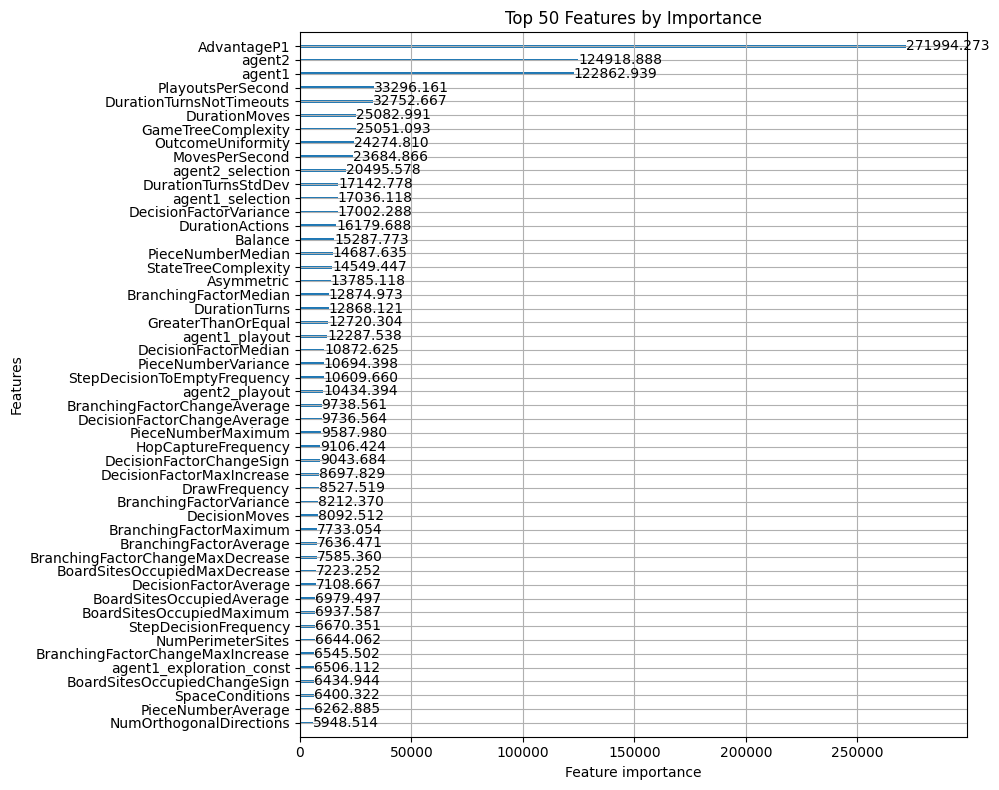

Fold 3 - RMSE: 0.4325443579087268
Fold 4


[100]	valid_0's rmse: 0.521883


[200]	valid_0's rmse: 0.495731


[300]	valid_0's rmse: 0.482754


[400]	valid_0's rmse: 0.474185


[500]	valid_0's rmse: 0.468935


[600]	valid_0's rmse: 0.465057


[700]	valid_0's rmse: 0.461724


[800]	valid_0's rmse: 0.459325


[900]	valid_0's rmse: 0.457173


[1000]	valid_0's rmse: 0.455538


[1100]	valid_0's rmse: 0.454261


[1200]	valid_0's rmse: 0.453136


[1300]	valid_0's rmse: 0.452021


[1400]	valid_0's rmse: 0.451075


[1500]	valid_0's rmse: 0.450394


[1600]	valid_0's rmse: 0.449925


[1700]	valid_0's rmse: 0.449275


[1800]	valid_0's rmse: 0.448784


[1900]	valid_0's rmse: 0.448181


[2000]	valid_0's rmse: 0.447515


[2100]	valid_0's rmse: 0.447041


[2200]	valid_0's rmse: 0.446543


[2300]	valid_0's rmse: 0.446161


[2400]	valid_0's rmse: 0.445834


[2500]	valid_0's rmse: 0.445497


[2600]	valid_0's rmse: 0.445158


[2700]	valid_0's rmse: 0.44484


[2800]	valid_0's rmse: 0.444534


[2900]	valid_0's rmse: 0.444144


[3000]	valid_0's rmse: 0.443818


[3100]	valid_0's rmse: 0.443621


[3200]	valid_0's rmse: 0.443373


[3300]	valid_0's rmse: 0.443191


[3400]	valid_0's rmse: 0.442996


[3500]	valid_0's rmse: 0.44283


[3600]	valid_0's rmse: 0.44265


[3700]	valid_0's rmse: 0.442516


[3800]	valid_0's rmse: 0.442387


[3900]	valid_0's rmse: 0.442234


[4000]	valid_0's rmse: 0.441943


[4100]	valid_0's rmse: 0.441816


[4200]	valid_0's rmse: 0.441651


[4300]	valid_0's rmse: 0.441481


[4400]	valid_0's rmse: 0.441404


[4500]	valid_0's rmse: 0.44124


[4600]	valid_0's rmse: 0.441179


[4700]	valid_0's rmse: 0.44104


[4800]	valid_0's rmse: 0.440962


[4900]	valid_0's rmse: 0.44088


[5000]	valid_0's rmse: 0.440817


[5100]	valid_0's rmse: 0.4407


[5200]	valid_0's rmse: 0.440637


[5300]	valid_0's rmse: 0.440551


[5400]	valid_0's rmse: 0.440479


[5500]	valid_0's rmse: 0.440456


[5600]	valid_0's rmse: 0.440365


[5700]	valid_0's rmse: 0.440316


[5800]	valid_0's rmse: 0.440278


[5900]	valid_0's rmse: 0.440196


[6000]	valid_0's rmse: 0.440138


[6100]	valid_0's rmse: 0.440053


[6200]	valid_0's rmse: 0.439971


[6300]	valid_0's rmse: 0.439873


[6400]	valid_0's rmse: 0.43981


[6500]	valid_0's rmse: 0.439792


[6600]	valid_0's rmse: 0.439662


[6700]	valid_0's rmse: 0.439649


[6800]	valid_0's rmse: 0.439646


[6900]	valid_0's rmse: 0.439551


[7000]	valid_0's rmse: 0.439533


[7100]	valid_0's rmse: 0.439517


[7200]	valid_0's rmse: 0.439463


[7300]	valid_0's rmse: 0.439503


[7400]	valid_0's rmse: 0.439459


[7500]	valid_0's rmse: 0.439341


[7600]	valid_0's rmse: 0.439301


[7700]	valid_0's rmse: 0.439216


[7800]	valid_0's rmse: 0.439258


[7900]	valid_0's rmse: 0.439175


[8000]	valid_0's rmse: 0.439145


[8100]	valid_0's rmse: 0.439046


[8200]	valid_0's rmse: 0.439


[8300]	valid_0's rmse: 0.438988


[8400]	valid_0's rmse: 0.438971


[8500]	valid_0's rmse: 0.439011


[8600]	valid_0's rmse: 0.438992


[8700]	valid_0's rmse: 0.438964


[8800]	valid_0's rmse: 0.43893


[8900]	valid_0's rmse: 0.438871


[9000]	valid_0's rmse: 0.438845


[9100]	valid_0's rmse: 0.438831


[9200]	valid_0's rmse: 0.43879


[9300]	valid_0's rmse: 0.438751


[9400]	valid_0's rmse: 0.438704


[9500]	valid_0's rmse: 0.438714


[9600]	valid_0's rmse: 0.438675


[9700]	valid_0's rmse: 0.438666


[9800]	valid_0's rmse: 0.438695


[9900]	valid_0's rmse: 0.438699


[10000]	valid_0's rmse: 0.438659


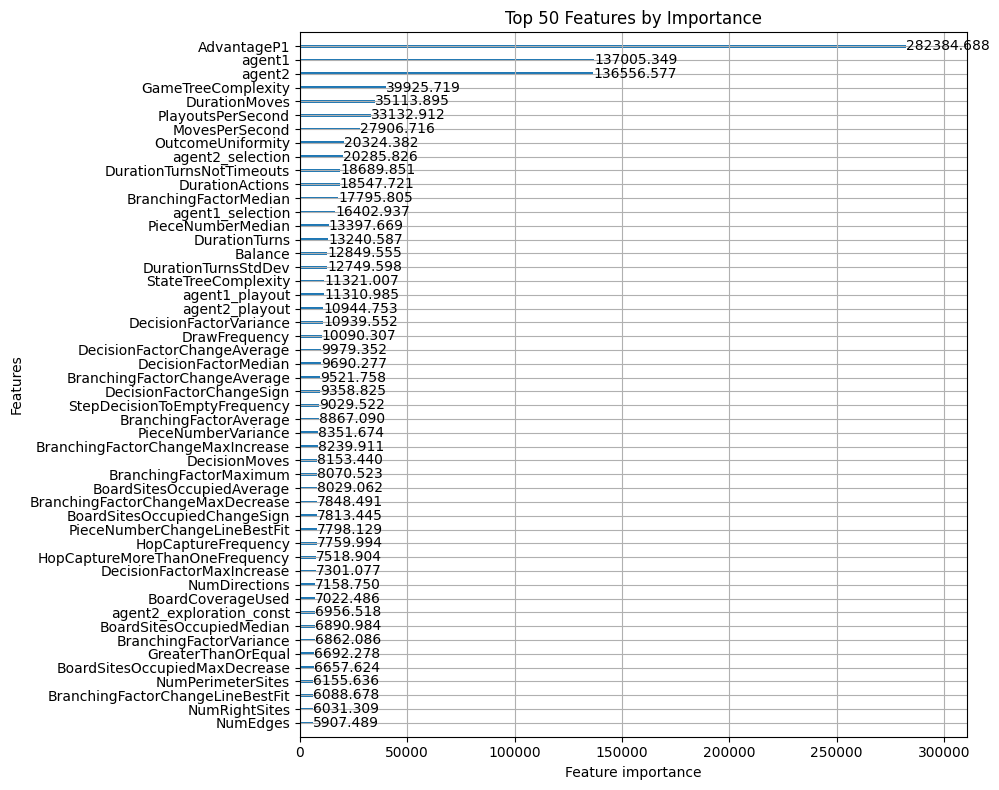

Fold 4 - RMSE: 0.43826817112612704
Fold 5


[100]	valid_0's rmse: 0.518593


[200]	valid_0's rmse: 0.494605


[300]	valid_0's rmse: 0.482657


[400]	valid_0's rmse: 0.473985


[500]	valid_0's rmse: 0.46716


[600]	valid_0's rmse: 0.462885


[700]	valid_0's rmse: 0.459059


[800]	valid_0's rmse: 0.455722


[900]	valid_0's rmse: 0.453115


[1000]	valid_0's rmse: 0.451319


[1100]	valid_0's rmse: 0.449326


[1200]	valid_0's rmse: 0.447407


[1300]	valid_0's rmse: 0.445859


[1400]	valid_0's rmse: 0.444692


[1500]	valid_0's rmse: 0.443863


[1600]	valid_0's rmse: 0.443211


[1700]	valid_0's rmse: 0.442407


[1800]	valid_0's rmse: 0.441712


[1900]	valid_0's rmse: 0.440933


[2000]	valid_0's rmse: 0.440602


[2100]	valid_0's rmse: 0.440144


[2200]	valid_0's rmse: 0.43962


[2300]	valid_0's rmse: 0.439253


[2400]	valid_0's rmse: 0.438643


[2500]	valid_0's rmse: 0.438232


[2600]	valid_0's rmse: 0.437933


[2700]	valid_0's rmse: 0.437594


[2800]	valid_0's rmse: 0.437194


[2900]	valid_0's rmse: 0.436999


[3000]	valid_0's rmse: 0.436701


[3100]	valid_0's rmse: 0.436535


[3200]	valid_0's rmse: 0.436271


[3300]	valid_0's rmse: 0.436053


[3400]	valid_0's rmse: 0.435919


[3500]	valid_0's rmse: 0.435625


[3600]	valid_0's rmse: 0.435586


[3700]	valid_0's rmse: 0.435467


[3800]	valid_0's rmse: 0.435378


[3900]	valid_0's rmse: 0.435215


[4000]	valid_0's rmse: 0.435041


[4100]	valid_0's rmse: 0.434797


[4200]	valid_0's rmse: 0.434644


[4300]	valid_0's rmse: 0.434441


[4400]	valid_0's rmse: 0.434357


[4500]	valid_0's rmse: 0.434195


[4600]	valid_0's rmse: 0.434019


[4700]	valid_0's rmse: 0.433903


[4800]	valid_0's rmse: 0.43373


[4900]	valid_0's rmse: 0.433628


[5000]	valid_0's rmse: 0.433524


[5100]	valid_0's rmse: 0.433416


[5200]	valid_0's rmse: 0.433321


[5300]	valid_0's rmse: 0.433236


[5400]	valid_0's rmse: 0.433156


[5500]	valid_0's rmse: 0.43306


[5600]	valid_0's rmse: 0.433055


[5700]	valid_0's rmse: 0.432986


[5800]	valid_0's rmse: 0.432905


[5900]	valid_0's rmse: 0.432821


[6000]	valid_0's rmse: 0.43269


[6100]	valid_0's rmse: 0.432654


[6200]	valid_0's rmse: 0.432586


[6300]	valid_0's rmse: 0.43253


[6400]	valid_0's rmse: 0.432466


[6500]	valid_0's rmse: 0.43241


[6600]	valid_0's rmse: 0.432401


[6700]	valid_0's rmse: 0.432339


[6800]	valid_0's rmse: 0.43228


[6900]	valid_0's rmse: 0.432191


[7000]	valid_0's rmse: 0.432163


[7100]	valid_0's rmse: 0.432108


[7200]	valid_0's rmse: 0.432025


[7300]	valid_0's rmse: 0.432013


[7400]	valid_0's rmse: 0.431947


[7500]	valid_0's rmse: 0.431894


[7600]	valid_0's rmse: 0.431831


[7700]	valid_0's rmse: 0.431807


[7800]	valid_0's rmse: 0.431776


[7900]	valid_0's rmse: 0.43174


[8000]	valid_0's rmse: 0.431745


[8100]	valid_0's rmse: 0.431725


[8200]	valid_0's rmse: 0.431669


[8300]	valid_0's rmse: 0.431599


[8400]	valid_0's rmse: 0.431547


[8500]	valid_0's rmse: 0.431531


[8600]	valid_0's rmse: 0.43149


[8700]	valid_0's rmse: 0.431478


[8800]	valid_0's rmse: 0.431517


[8900]	valid_0's rmse: 0.431462


[9000]	valid_0's rmse: 0.43145


[9100]	valid_0's rmse: 0.431421


[9200]	valid_0's rmse: 0.431452


[9300]	valid_0's rmse: 0.431476


[9400]	valid_0's rmse: 0.431485


[9500]	valid_0's rmse: 0.431447


[9600]	valid_0's rmse: 0.431398


[9700]	valid_0's rmse: 0.431358


[9800]	valid_0's rmse: 0.431292


[9900]	valid_0's rmse: 0.4313


[10000]	valid_0's rmse: 0.43124


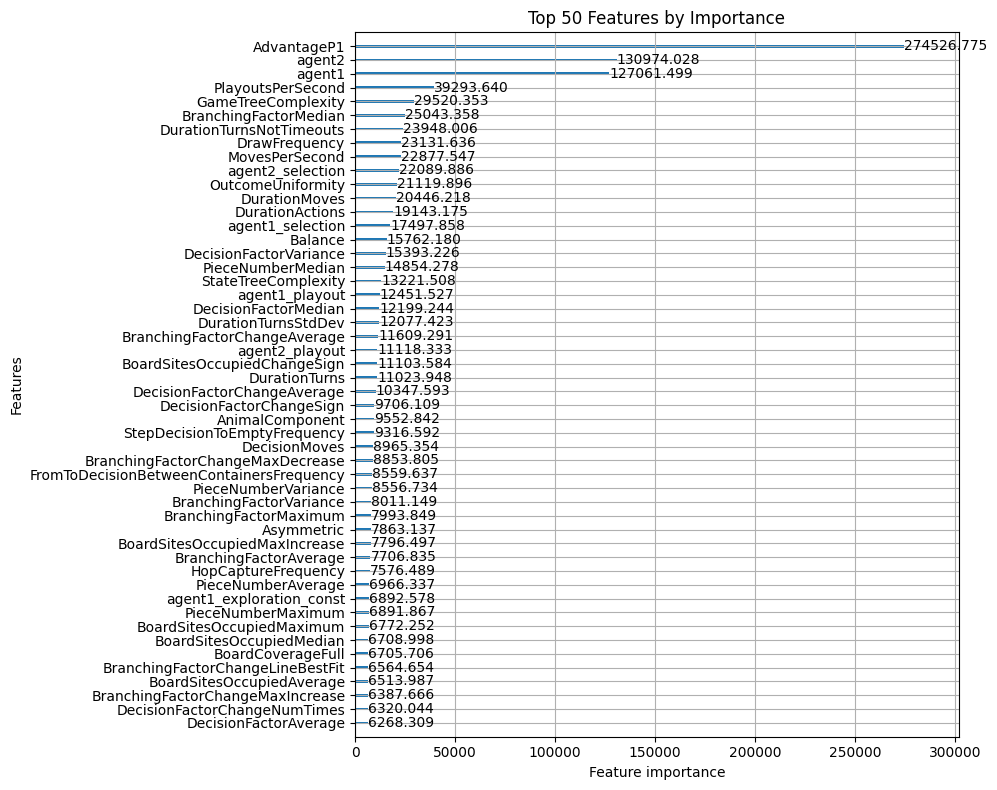

Fold 5 - RMSE: 0.4305057297419652
List of oof scores: [0.41065420579768597, 0.40078199410353343, 0.4325443579087268, 0.43826817112612704, 0.4305057297419652]
Average oof score: 0.42255089173560767


In [12]:
# call the function
trained_models2, oof2, oof_scores2, importance_df2 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split2,
)
# save oof predictions
oof2.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv2.parquet', index=False)

Fold 1


[100]	valid_0's rmse: 0.507058


[200]	valid_0's rmse: 0.483211


[300]	valid_0's rmse: 0.471005


[400]	valid_0's rmse: 0.46366


[500]	valid_0's rmse: 0.458997


[600]	valid_0's rmse: 0.455861


[700]	valid_0's rmse: 0.453456


[800]	valid_0's rmse: 0.451038


[900]	valid_0's rmse: 0.449543


[1000]	valid_0's rmse: 0.448141


[1100]	valid_0's rmse: 0.446559


[1200]	valid_0's rmse: 0.445276


[1300]	valid_0's rmse: 0.444278


[1400]	valid_0's rmse: 0.443314


[1500]	valid_0's rmse: 0.442401


[1600]	valid_0's rmse: 0.441577


[1700]	valid_0's rmse: 0.44091


[1800]	valid_0's rmse: 0.440291


[1900]	valid_0's rmse: 0.439729


[2000]	valid_0's rmse: 0.439151


[2100]	valid_0's rmse: 0.438659


[2200]	valid_0's rmse: 0.438313


[2300]	valid_0's rmse: 0.437944


[2400]	valid_0's rmse: 0.437605


[2500]	valid_0's rmse: 0.437222


[2600]	valid_0's rmse: 0.436862


[2700]	valid_0's rmse: 0.436589


[2800]	valid_0's rmse: 0.436307


[2900]	valid_0's rmse: 0.435946


[3000]	valid_0's rmse: 0.435791


[3100]	valid_0's rmse: 0.435567


[3200]	valid_0's rmse: 0.435469


[3300]	valid_0's rmse: 0.435261


[3400]	valid_0's rmse: 0.435093


[3500]	valid_0's rmse: 0.434905


[3600]	valid_0's rmse: 0.434787


[3700]	valid_0's rmse: 0.434546


[3800]	valid_0's rmse: 0.434447


[3900]	valid_0's rmse: 0.434322


[4000]	valid_0's rmse: 0.434081


[4100]	valid_0's rmse: 0.43395


[4200]	valid_0's rmse: 0.433836


[4300]	valid_0's rmse: 0.433654


[4400]	valid_0's rmse: 0.43342


[4500]	valid_0's rmse: 0.433286


[4600]	valid_0's rmse: 0.433176


[4700]	valid_0's rmse: 0.433018


[4800]	valid_0's rmse: 0.432954


[4900]	valid_0's rmse: 0.432923


[5000]	valid_0's rmse: 0.432779


[5100]	valid_0's rmse: 0.432796


[5200]	valid_0's rmse: 0.432702


[5300]	valid_0's rmse: 0.432555


[5400]	valid_0's rmse: 0.432455


[5500]	valid_0's rmse: 0.432466


[5600]	valid_0's rmse: 0.432504


[5700]	valid_0's rmse: 0.43244


[5800]	valid_0's rmse: 0.432452


[5900]	valid_0's rmse: 0.43239


[6000]	valid_0's rmse: 0.43231


[6100]	valid_0's rmse: 0.432309


[6200]	valid_0's rmse: 0.432256


[6300]	valid_0's rmse: 0.432177


[6400]	valid_0's rmse: 0.432153


[6500]	valid_0's rmse: 0.432085


[6600]	valid_0's rmse: 0.432105


[6700]	valid_0's rmse: 0.432103


[6800]	valid_0's rmse: 0.432032


[6900]	valid_0's rmse: 0.431979


[7000]	valid_0's rmse: 0.431913


[7100]	valid_0's rmse: 0.431877


[7200]	valid_0's rmse: 0.431815


[7300]	valid_0's rmse: 0.431751


[7400]	valid_0's rmse: 0.431708


[7500]	valid_0's rmse: 0.431685


[7600]	valid_0's rmse: 0.431684


[7700]	valid_0's rmse: 0.43167


[7800]	valid_0's rmse: 0.431712


[7900]	valid_0's rmse: 0.431691


[8000]	valid_0's rmse: 0.431654


[8100]	valid_0's rmse: 0.431576


[8200]	valid_0's rmse: 0.431553


[8300]	valid_0's rmse: 0.431553


[8400]	valid_0's rmse: 0.43156


[8500]	valid_0's rmse: 0.431607


[8600]	valid_0's rmse: 0.431579


[8700]	valid_0's rmse: 0.431555


[8800]	valid_0's rmse: 0.431519


[8900]	valid_0's rmse: 0.431532


[9000]	valid_0's rmse: 0.431526


[9100]	valid_0's rmse: 0.431541


[9200]	valid_0's rmse: 0.431511


[9300]	valid_0's rmse: 0.43149


[9400]	valid_0's rmse: 0.431512


[9500]	valid_0's rmse: 0.43148


[9600]	valid_0's rmse: 0.431541


[9700]	valid_0's rmse: 0.431531


[9800]	valid_0's rmse: 0.431499


[9900]	valid_0's rmse: 0.431501


[10000]	valid_0's rmse: 0.431539


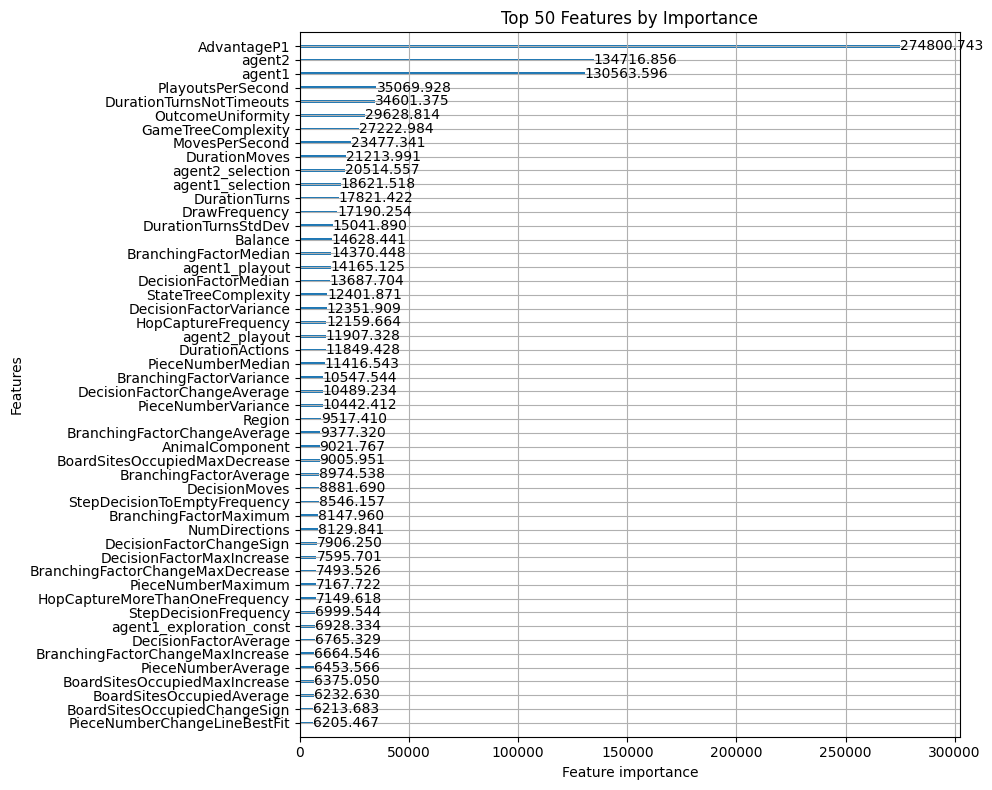

Fold 1 - RMSE: 0.4309722207117219
Fold 2


[100]	valid_0's rmse: 0.505113


[200]	valid_0's rmse: 0.477519


[300]	valid_0's rmse: 0.463938


[400]	valid_0's rmse: 0.454882


[500]	valid_0's rmse: 0.448787


[600]	valid_0's rmse: 0.444165


[700]	valid_0's rmse: 0.440082


[800]	valid_0's rmse: 0.437256


[900]	valid_0's rmse: 0.434516


[1000]	valid_0's rmse: 0.432537


[1100]	valid_0's rmse: 0.430917


[1200]	valid_0's rmse: 0.429516


[1300]	valid_0's rmse: 0.428127


[1400]	valid_0's rmse: 0.426967


[1500]	valid_0's rmse: 0.425773


[1600]	valid_0's rmse: 0.424955


[1700]	valid_0's rmse: 0.424059


[1800]	valid_0's rmse: 0.423271


[1900]	valid_0's rmse: 0.422564


[2000]	valid_0's rmse: 0.421918


[2100]	valid_0's rmse: 0.421169


[2200]	valid_0's rmse: 0.420689


[2300]	valid_0's rmse: 0.420275


[2400]	valid_0's rmse: 0.419875


[2500]	valid_0's rmse: 0.419502


[2600]	valid_0's rmse: 0.419136


[2700]	valid_0's rmse: 0.418786


[2800]	valid_0's rmse: 0.418462


[2900]	valid_0's rmse: 0.418153


[3000]	valid_0's rmse: 0.417893


[3100]	valid_0's rmse: 0.41753


[3200]	valid_0's rmse: 0.417263


[3300]	valid_0's rmse: 0.416967


[3400]	valid_0's rmse: 0.4167


[3500]	valid_0's rmse: 0.416514


[3600]	valid_0's rmse: 0.416274


[3700]	valid_0's rmse: 0.416149


[3800]	valid_0's rmse: 0.416005


[3900]	valid_0's rmse: 0.415832


[4000]	valid_0's rmse: 0.415548


[4100]	valid_0's rmse: 0.415361


[4200]	valid_0's rmse: 0.415175


[4300]	valid_0's rmse: 0.41509


[4400]	valid_0's rmse: 0.414983


[4500]	valid_0's rmse: 0.414844


[4600]	valid_0's rmse: 0.414791


[4700]	valid_0's rmse: 0.414662


[4800]	valid_0's rmse: 0.414607


[4900]	valid_0's rmse: 0.414436


[5000]	valid_0's rmse: 0.414261


[5100]	valid_0's rmse: 0.414151


[5200]	valid_0's rmse: 0.414018


[5300]	valid_0's rmse: 0.413848


[5400]	valid_0's rmse: 0.413721


[5500]	valid_0's rmse: 0.413667


[5600]	valid_0's rmse: 0.413527


[5700]	valid_0's rmse: 0.413513


[5800]	valid_0's rmse: 0.413393


[5900]	valid_0's rmse: 0.4133


[6000]	valid_0's rmse: 0.413258


[6100]	valid_0's rmse: 0.413143


[6200]	valid_0's rmse: 0.413079


[6300]	valid_0's rmse: 0.413056


[6400]	valid_0's rmse: 0.412987


[6500]	valid_0's rmse: 0.412933


[6600]	valid_0's rmse: 0.41286


[6700]	valid_0's rmse: 0.412872


[6800]	valid_0's rmse: 0.412834


[6900]	valid_0's rmse: 0.412775


[7000]	valid_0's rmse: 0.412667


[7100]	valid_0's rmse: 0.412598


[7200]	valid_0's rmse: 0.412548


[7300]	valid_0's rmse: 0.412451


[7400]	valid_0's rmse: 0.41239


[7500]	valid_0's rmse: 0.412294


[7600]	valid_0's rmse: 0.412204


[7700]	valid_0's rmse: 0.412114


[7800]	valid_0's rmse: 0.412055


[7900]	valid_0's rmse: 0.411952


[8000]	valid_0's rmse: 0.411928


[8100]	valid_0's rmse: 0.411917


[8200]	valid_0's rmse: 0.411888


[8300]	valid_0's rmse: 0.411852


[8400]	valid_0's rmse: 0.411856


[8500]	valid_0's rmse: 0.411884


[8600]	valid_0's rmse: 0.41178


[8700]	valid_0's rmse: 0.411775


[8800]	valid_0's rmse: 0.411726


[8900]	valid_0's rmse: 0.41169


[9000]	valid_0's rmse: 0.411703


[9100]	valid_0's rmse: 0.41167


[9200]	valid_0's rmse: 0.41166


[9300]	valid_0's rmse: 0.411676


[9400]	valid_0's rmse: 0.411696


[9500]	valid_0's rmse: 0.411689


[9600]	valid_0's rmse: 0.411634


[9700]	valid_0's rmse: 0.411616


[9800]	valid_0's rmse: 0.411597


[9900]	valid_0's rmse: 0.411565


[10000]	valid_0's rmse: 0.411594


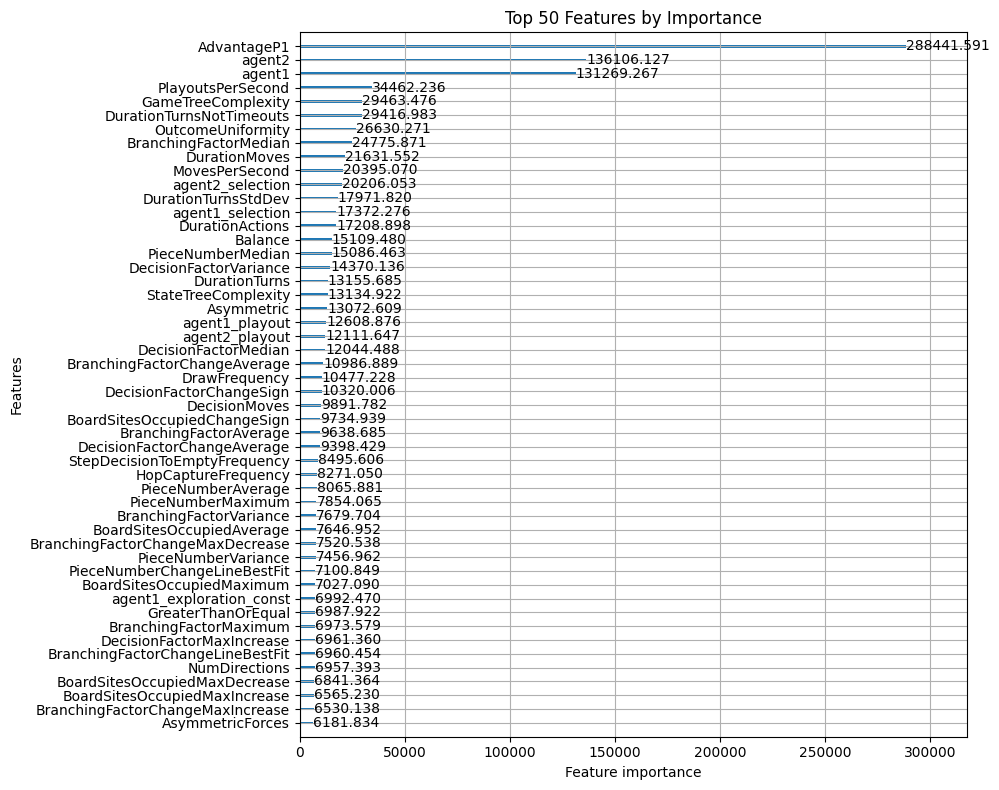

Fold 2 - RMSE: 0.4110969986732781
Fold 3


[100]	valid_0's rmse: 0.496128


[200]	valid_0's rmse: 0.472468


[300]	valid_0's rmse: 0.461385


[400]	valid_0's rmse: 0.454108


[500]	valid_0's rmse: 0.448959


[600]	valid_0's rmse: 0.445487


[700]	valid_0's rmse: 0.442904


[800]	valid_0's rmse: 0.440607


[900]	valid_0's rmse: 0.438819


[1000]	valid_0's rmse: 0.437201


[1100]	valid_0's rmse: 0.435822


[1200]	valid_0's rmse: 0.434545


[1300]	valid_0's rmse: 0.433625


[1400]	valid_0's rmse: 0.432708


[1500]	valid_0's rmse: 0.431972


[1600]	valid_0's rmse: 0.431413


[1700]	valid_0's rmse: 0.430815


[1800]	valid_0's rmse: 0.430181


[1900]	valid_0's rmse: 0.429652


[2000]	valid_0's rmse: 0.428966


[2100]	valid_0's rmse: 0.428547


[2200]	valid_0's rmse: 0.428178


[2300]	valid_0's rmse: 0.428002


[2400]	valid_0's rmse: 0.427747


[2500]	valid_0's rmse: 0.427405


[2600]	valid_0's rmse: 0.426956


[2700]	valid_0's rmse: 0.426811


[2800]	valid_0's rmse: 0.426516


[2900]	valid_0's rmse: 0.426207


[3000]	valid_0's rmse: 0.425998


[3100]	valid_0's rmse: 0.425762


[3200]	valid_0's rmse: 0.425611


[3300]	valid_0's rmse: 0.425391


[3400]	valid_0's rmse: 0.425245


[3500]	valid_0's rmse: 0.425047


[3600]	valid_0's rmse: 0.424828


[3700]	valid_0's rmse: 0.424595


[3800]	valid_0's rmse: 0.424513


[3900]	valid_0's rmse: 0.42438


[4000]	valid_0's rmse: 0.424244


[4100]	valid_0's rmse: 0.424106


[4200]	valid_0's rmse: 0.423892


[4300]	valid_0's rmse: 0.423812


[4400]	valid_0's rmse: 0.423675


[4500]	valid_0's rmse: 0.423537


[4600]	valid_0's rmse: 0.423405


[4700]	valid_0's rmse: 0.423314


[4800]	valid_0's rmse: 0.423234


[4900]	valid_0's rmse: 0.423115


[5000]	valid_0's rmse: 0.422998


[5100]	valid_0's rmse: 0.422913


[5200]	valid_0's rmse: 0.422823


[5300]	valid_0's rmse: 0.422735


[5400]	valid_0's rmse: 0.422699


[5500]	valid_0's rmse: 0.422585


[5600]	valid_0's rmse: 0.422467


[5700]	valid_0's rmse: 0.422329


[5800]	valid_0's rmse: 0.422272


[5900]	valid_0's rmse: 0.422214


[6000]	valid_0's rmse: 0.422106


[6100]	valid_0's rmse: 0.422055


[6200]	valid_0's rmse: 0.421998


[6300]	valid_0's rmse: 0.422014


[6400]	valid_0's rmse: 0.421973


[6500]	valid_0's rmse: 0.421957


[6600]	valid_0's rmse: 0.421894


[6700]	valid_0's rmse: 0.421883


[6800]	valid_0's rmse: 0.421846


[6900]	valid_0's rmse: 0.421854


[7000]	valid_0's rmse: 0.421731


[7100]	valid_0's rmse: 0.421688


[7200]	valid_0's rmse: 0.421644


[7300]	valid_0's rmse: 0.421641


[7400]	valid_0's rmse: 0.421679


[7500]	valid_0's rmse: 0.421619


[7600]	valid_0's rmse: 0.421566


[7700]	valid_0's rmse: 0.421535


[7800]	valid_0's rmse: 0.421446


[7900]	valid_0's rmse: 0.42139


[8000]	valid_0's rmse: 0.421364


[8100]	valid_0's rmse: 0.421354


[8200]	valid_0's rmse: 0.421306


[8300]	valid_0's rmse: 0.421244


[8400]	valid_0's rmse: 0.421241


[8500]	valid_0's rmse: 0.42124


[8600]	valid_0's rmse: 0.421137


[8700]	valid_0's rmse: 0.421048


[8800]	valid_0's rmse: 0.42102


[8900]	valid_0's rmse: 0.420972


[9000]	valid_0's rmse: 0.420941


[9100]	valid_0's rmse: 0.420926


[9200]	valid_0's rmse: 0.420957


[9300]	valid_0's rmse: 0.420925


[9400]	valid_0's rmse: 0.420939


[9500]	valid_0's rmse: 0.420922


[9600]	valid_0's rmse: 0.420866


[9700]	valid_0's rmse: 0.420859


[9800]	valid_0's rmse: 0.420886


[9900]	valid_0's rmse: 0.420884


[10000]	valid_0's rmse: 0.420825


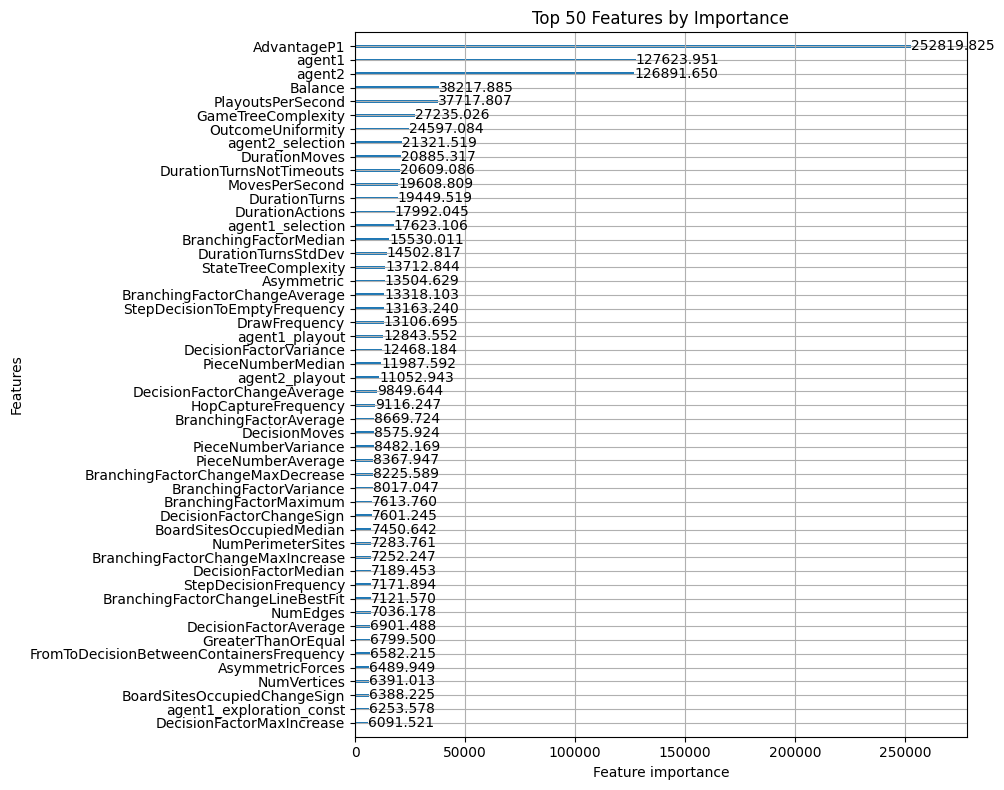

Fold 3 - RMSE: 0.4203937221052381
Fold 4


[100]	valid_0's rmse: 0.488013


[200]	valid_0's rmse: 0.466223


[300]	valid_0's rmse: 0.455615


[400]	valid_0's rmse: 0.449478


[500]	valid_0's rmse: 0.44425


[600]	valid_0's rmse: 0.440749


[700]	valid_0's rmse: 0.437478


[800]	valid_0's rmse: 0.434928


[900]	valid_0's rmse: 0.433248


[1000]	valid_0's rmse: 0.431714


[1100]	valid_0's rmse: 0.430273


[1200]	valid_0's rmse: 0.429058


[1300]	valid_0's rmse: 0.427924


[1400]	valid_0's rmse: 0.427134


[1500]	valid_0's rmse: 0.42599


[1600]	valid_0's rmse: 0.425185


[1700]	valid_0's rmse: 0.424705


[1800]	valid_0's rmse: 0.424106


[1900]	valid_0's rmse: 0.423479


[2000]	valid_0's rmse: 0.422966


[2100]	valid_0's rmse: 0.422689


[2200]	valid_0's rmse: 0.42232


[2300]	valid_0's rmse: 0.42185


[2400]	valid_0's rmse: 0.421593


[2500]	valid_0's rmse: 0.421274


[2600]	valid_0's rmse: 0.420901


[2700]	valid_0's rmse: 0.420495


[2800]	valid_0's rmse: 0.420195


[2900]	valid_0's rmse: 0.419923


[3000]	valid_0's rmse: 0.419614


[3100]	valid_0's rmse: 0.419373


[3200]	valid_0's rmse: 0.419156


[3300]	valid_0's rmse: 0.418959


[3400]	valid_0's rmse: 0.418777


[3500]	valid_0's rmse: 0.418553


[3600]	valid_0's rmse: 0.418312


[3700]	valid_0's rmse: 0.418071


[3800]	valid_0's rmse: 0.417872


[3900]	valid_0's rmse: 0.417712


[4000]	valid_0's rmse: 0.417491


[4100]	valid_0's rmse: 0.417264


[4200]	valid_0's rmse: 0.417203


[4300]	valid_0's rmse: 0.417044


[4400]	valid_0's rmse: 0.416914


[4500]	valid_0's rmse: 0.416855


[4600]	valid_0's rmse: 0.416698


[4700]	valid_0's rmse: 0.416645


[4800]	valid_0's rmse: 0.416514


[4900]	valid_0's rmse: 0.416359


[5000]	valid_0's rmse: 0.416301


[5100]	valid_0's rmse: 0.416209


[5200]	valid_0's rmse: 0.416128


[5300]	valid_0's rmse: 0.416078


[5400]	valid_0's rmse: 0.415924


[5500]	valid_0's rmse: 0.415908


[5600]	valid_0's rmse: 0.415827


[5700]	valid_0's rmse: 0.415786


[5800]	valid_0's rmse: 0.415776


[5900]	valid_0's rmse: 0.415714


[6000]	valid_0's rmse: 0.415656


[6100]	valid_0's rmse: 0.41559


[6200]	valid_0's rmse: 0.415611


[6300]	valid_0's rmse: 0.415522


[6400]	valid_0's rmse: 0.41545


[6500]	valid_0's rmse: 0.415462


[6600]	valid_0's rmse: 0.41542


[6700]	valid_0's rmse: 0.415284


[6800]	valid_0's rmse: 0.415248


[6900]	valid_0's rmse: 0.415211


[7000]	valid_0's rmse: 0.415132


[7100]	valid_0's rmse: 0.415128


[7200]	valid_0's rmse: 0.41513


[7300]	valid_0's rmse: 0.415148


[7400]	valid_0's rmse: 0.415131


[7500]	valid_0's rmse: 0.415109


[7600]	valid_0's rmse: 0.41506


[7700]	valid_0's rmse: 0.415045


[7800]	valid_0's rmse: 0.415038


[7900]	valid_0's rmse: 0.415004


[8000]	valid_0's rmse: 0.414955


[8100]	valid_0's rmse: 0.414959


[8200]	valid_0's rmse: 0.414905


[8300]	valid_0's rmse: 0.41485


[8400]	valid_0's rmse: 0.414794


[8500]	valid_0's rmse: 0.414799


[8600]	valid_0's rmse: 0.414792


[8700]	valid_0's rmse: 0.414772


[8800]	valid_0's rmse: 0.414769


[8900]	valid_0's rmse: 0.414759


[9000]	valid_0's rmse: 0.414689


[9100]	valid_0's rmse: 0.414641


[9200]	valid_0's rmse: 0.414595


[9300]	valid_0's rmse: 0.414559


[9400]	valid_0's rmse: 0.41452


[9500]	valid_0's rmse: 0.41449


[9600]	valid_0's rmse: 0.414492


[9700]	valid_0's rmse: 0.414436


[9800]	valid_0's rmse: 0.414448


[9900]	valid_0's rmse: 0.414467


[10000]	valid_0's rmse: 0.414492


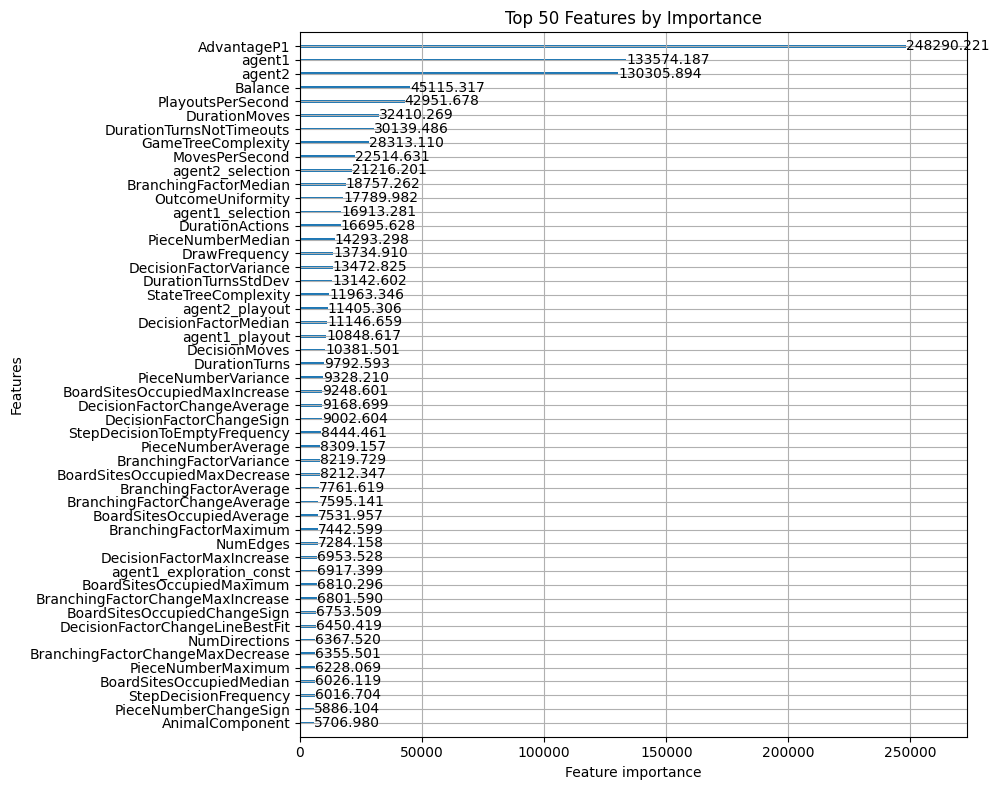

Fold 4 - RMSE: 0.4137844440074365
Fold 5


[100]	valid_0's rmse: 0.508032


[200]	valid_0's rmse: 0.487762


[300]	valid_0's rmse: 0.474453


[400]	valid_0's rmse: 0.467111


[500]	valid_0's rmse: 0.461497


[600]	valid_0's rmse: 0.457237


[700]	valid_0's rmse: 0.453826


[800]	valid_0's rmse: 0.450951


[900]	valid_0's rmse: 0.44815


[1000]	valid_0's rmse: 0.446306


[1100]	valid_0's rmse: 0.444667


[1200]	valid_0's rmse: 0.443277


[1300]	valid_0's rmse: 0.441823


[1400]	valid_0's rmse: 0.440723


[1500]	valid_0's rmse: 0.439773


[1600]	valid_0's rmse: 0.439026


[1700]	valid_0's rmse: 0.438314


[1800]	valid_0's rmse: 0.437505


[1900]	valid_0's rmse: 0.436756


[2000]	valid_0's rmse: 0.436126


[2100]	valid_0's rmse: 0.435606


[2200]	valid_0's rmse: 0.435044


[2300]	valid_0's rmse: 0.434591


[2400]	valid_0's rmse: 0.434297


[2500]	valid_0's rmse: 0.433904


[2600]	valid_0's rmse: 0.433525


[2700]	valid_0's rmse: 0.433156


[2800]	valid_0's rmse: 0.432747


[2900]	valid_0's rmse: 0.432332


[3000]	valid_0's rmse: 0.432112


[3100]	valid_0's rmse: 0.431882


[3200]	valid_0's rmse: 0.431648


[3300]	valid_0's rmse: 0.431325


[3400]	valid_0's rmse: 0.431189


[3500]	valid_0's rmse: 0.430943


[3600]	valid_0's rmse: 0.430814


[3700]	valid_0's rmse: 0.430614


[3800]	valid_0's rmse: 0.430448


[3900]	valid_0's rmse: 0.430201


[4000]	valid_0's rmse: 0.430055


[4100]	valid_0's rmse: 0.429918


[4200]	valid_0's rmse: 0.429801


[4300]	valid_0's rmse: 0.429603


[4400]	valid_0's rmse: 0.429435


[4500]	valid_0's rmse: 0.429377


[4600]	valid_0's rmse: 0.429309


[4700]	valid_0's rmse: 0.429145


[4800]	valid_0's rmse: 0.428967


[4900]	valid_0's rmse: 0.428857


[5000]	valid_0's rmse: 0.428828


[5100]	valid_0's rmse: 0.428739


[5200]	valid_0's rmse: 0.428683


[5300]	valid_0's rmse: 0.428565


[5400]	valid_0's rmse: 0.428419


[5500]	valid_0's rmse: 0.428341


[5600]	valid_0's rmse: 0.428232


[5700]	valid_0's rmse: 0.428056


[5800]	valid_0's rmse: 0.428034


[5900]	valid_0's rmse: 0.427851


[6000]	valid_0's rmse: 0.427715


[6100]	valid_0's rmse: 0.427595


[6200]	valid_0's rmse: 0.427547


[6300]	valid_0's rmse: 0.427457


[6400]	valid_0's rmse: 0.427382


[6500]	valid_0's rmse: 0.427307


[6600]	valid_0's rmse: 0.42722


[6700]	valid_0's rmse: 0.427057


[6800]	valid_0's rmse: 0.427001


[6900]	valid_0's rmse: 0.426868


[7000]	valid_0's rmse: 0.426802


[7100]	valid_0's rmse: 0.42678


[7200]	valid_0's rmse: 0.426739


[7300]	valid_0's rmse: 0.426664


[7400]	valid_0's rmse: 0.426647


[7500]	valid_0's rmse: 0.426592


[7600]	valid_0's rmse: 0.426551


[7700]	valid_0's rmse: 0.426504


[7800]	valid_0's rmse: 0.426452


[7900]	valid_0's rmse: 0.426443


[8000]	valid_0's rmse: 0.426454


[8100]	valid_0's rmse: 0.426409


[8200]	valid_0's rmse: 0.426308


[8300]	valid_0's rmse: 0.426243


[8400]	valid_0's rmse: 0.426191


[8500]	valid_0's rmse: 0.426175


[8600]	valid_0's rmse: 0.426109


[8700]	valid_0's rmse: 0.426018


[8800]	valid_0's rmse: 0.425985


[8900]	valid_0's rmse: 0.425936


[9000]	valid_0's rmse: 0.425925


[9100]	valid_0's rmse: 0.42593


[9200]	valid_0's rmse: 0.42589


[9300]	valid_0's rmse: 0.425856


[9400]	valid_0's rmse: 0.425839


[9500]	valid_0's rmse: 0.425834


[9600]	valid_0's rmse: 0.425828


[9700]	valid_0's rmse: 0.425891


[9800]	valid_0's rmse: 0.42593


[9900]	valid_0's rmse: 0.425946


[10000]	valid_0's rmse: 0.425859


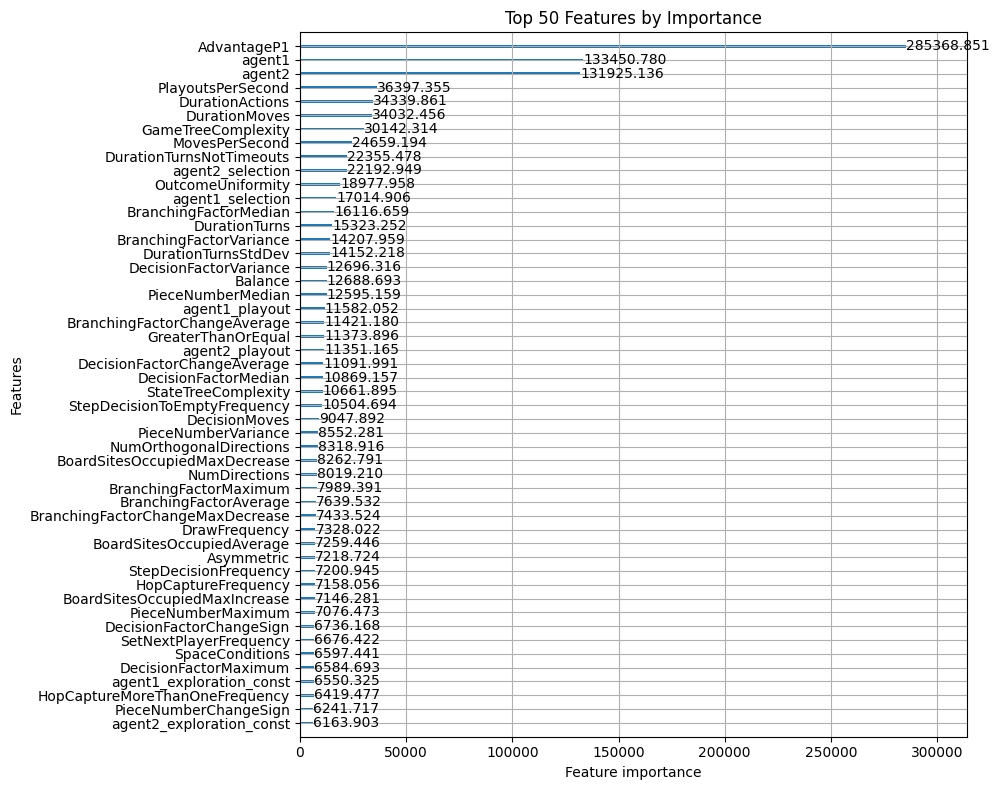

Fold 5 - RMSE: 0.4253457489628074
List of oof scores: [0.4309722207117219, 0.4110969986732781, 0.4203937221052381, 0.4137844440074365, 0.4253457489628074]
Average oof score: 0.4203186268920964


In [13]:
# call the function
trained_models3, oof3, oof_scores3, importance_df3 = train_models(
    df_train,
    numerical_cols,
    categorical_cols,
    split_list=split3,
)
# save oof predictions
oof3.to_parquet(path_results / f'oof_lightgbm_{fs_type}_cv3.parquet', index=False)

In [14]:
# Print summary of OOF scores for each CV fold
print("CV1 OOF Scores:")
for score in oof_scores1:
    print(f"Score: {score:.4f}")
print(f"Average CV1 Score: {sum(oof_scores1)/len(oof_scores1):.4f}")
    
print("\nCV2 OOF Scores:")  
for score in oof_scores2:
    print(f"Score: {score:.4f}")
print(f"Average CV2 Score: {sum(oof_scores2)/len(oof_scores2):.4f}")
    
print("\nCV3 OOF Scores:")
for score in oof_scores3:
    print(f"Score: {score:.4f}")
print(f"Average CV3 Score: {sum(oof_scores3)/len(oof_scores3):.4f}")

CV1 OOF Scores:
Score: 0.4299
Score: 0.4462
Score: 0.4407
Score: 0.4382
Score: 0.4067
Average CV1 Score: 0.4323

CV2 OOF Scores:
Score: 0.4107
Score: 0.4008
Score: 0.4325
Score: 0.4383
Score: 0.4305
Average CV2 Score: 0.4226

CV3 OOF Scores:
Score: 0.4310
Score: 0.4111
Score: 0.4204
Score: 0.4138
Score: 0.4253
Average CV3 Score: 0.4203


In [15]:
trained_models = [*trained_models1, *trained_models2, *trained_models3]
# trained_models = trained_models1

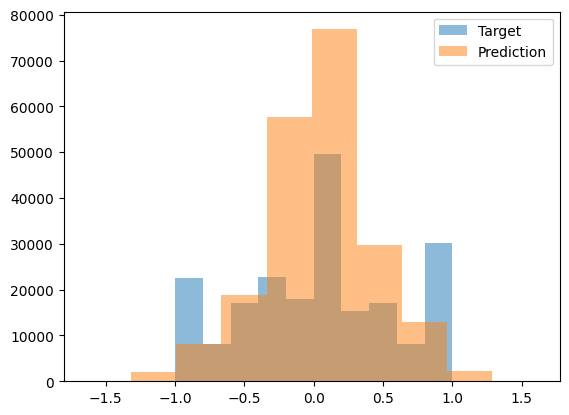

In [16]:
plt.hist(oof1['utility_agent1_true'], alpha=0.5, label='Target')
plt.hist(oof1['utility_agent1_pred'], alpha=0.5, label='Prediction')
plt.legend()
plt.show()

***
### inference

In [17]:
import os
import polars as pl
sys.path.append("../data/raw/")
import kaggle_evaluation.mcts_inference_server

In [18]:
def predict(test: pl.DataFrame, sample_sub: pl.DataFrame,):   
    # Convert Polars DataFrame to Pandas DataFrame
    test_pd = test.to_pandas()
    
    # Process the test data
    test_processed = process_test_data(
        test_pd,
        numerical_cols,
        categorical_cols,
        encoder,
        scaler
    )

    # Average predictions from all models
    predictions = [
        model.predict(test_processed[numerical_cols + categorical_cols]) 
        for model in trained_models
    ]
    predictions = np.mean(predictions, axis=0)
    predictions = np.clip(predictions, -1, 1)
        
    # Create the submission DataFrame
    submission = sample_sub.with_columns(pl.Series("utility_agent1", predictions))
    
    return submission

In [19]:
# sanity check
df_test = pl.read_csv('../data/raw/test.csv')
sample_sub = pl.read_csv('../data/raw/sample_submission.csv')
predict(df_test, sample_sub)

shape: (3, 2)
┌────────┬────────────────┐
│ Id     ┆ utility_agent1 │
│ ---    ┆ ---            │
│ i64    ┆ f64            │
╞════════╪════════════════╡
│ 233234 ┆ 0.125307       │
│ 233235 ┆ -0.173386      │
│ 233236 ┆ -0.011503      │
└────────┴────────────────┘

In [20]:
inference_server = kaggle_evaluation.mcts_inference_server.MCTSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '../data/raw/test.csv',
            '../data/raw/sample_submission.csv'
        )
    )

In [21]:
# Save all artifacts needed for prediction
lightgbm_predict = {
    'models': trained_models,
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols, 
    'encoder': encoder,
    'scaler': scaler
}

with open(f'./lightgbm_predict_{fs_type}.pkl', 'wb') as f:
    pickle.dump(lightgbm_predict, f)

***